<h1><center> Frontal Low-Level Jet analysis  </center></h1>
<div style="text-align: center"> 
    Dr. Harish Baki <br/> Postdoctoral researcher <br/> TU Delft, Netherlands <br/> Email: h.baki@tudelft.nl<br/>
</div>

In [150]:
import datetime
print(f'Updated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Updated: 2024-06-14 13:34:22


In [151]:
import xarray as xr
from netCDF4 import Dataset
import os
import glob
import dask.distributed as dd
import dask
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product

import wrf
from wrf import interplevel

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import HourLocator, DateFormatter, MinuteLocator

import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from windrose import WindroseAxes

from scipy.stats import weibull_min

import seaborn as sns
import seaborn.objects as so

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

from scipy.stats import linregress


from meteostat import Stations
from datetime import datetime
from meteostat import Hourly

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2

import wrf
from wrf import (getvar, interplevel, vertcross,
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 interpline, ll_to_xy,extract_global_attrs)

root_dir = '/media/harish/SSD_4TB/EU_SCORES_project/WRFV4.4/FLLJ'
scripts_dir = f'{root_dir}/scripts'
sys.path.append(scripts_dir)

from data_processing.libraries import *

In [201]:
fig_dir = '/home/harish/Dropbox/Apps/Overleaf/Modelling Frontal Low-level Jets and Associated Extreme Wind Ramps'
buoy_locations = {'LOT1': [51.706898,3.034618], 'LOT2': [51.6463,2.95141]}

run_names = ['ERA5-3d1kmMYFP',
             'CERRA-2d1kmMYFP','CERRA-2d1kmMYnoFP','CERRA-2d1kmSH','CERRA-1d1kmMYFP','CERRA-2d0.5kmSH','CERRA-1d0.5kmSH',
             'GFS-3d1kmMYFP',
             'CERRA-2d1kmMYFP','CERRA-2d1kmMYnoFP','CERRA-2d1kmSH','CERRA-1d1kmMYFP','CERRA-2d0.5kmSH','CERRA-1d0.5kmSH',
             'CERRA-1d1kmSH']
time_instances = ['2016-02-22T06:00','2016-03-04T07:30']
contour_levels = [[np.arange(0, 30.1, 1),np.arange(0,30.1,1),np.arange(-15, 16, 1)],
                  [np.arange(0, 30.1, 1),np.arange(0,30.1,1),np.arange(-10, 11, 1)]]
angles = [165,450]

# Spatial plot of WRF model domains

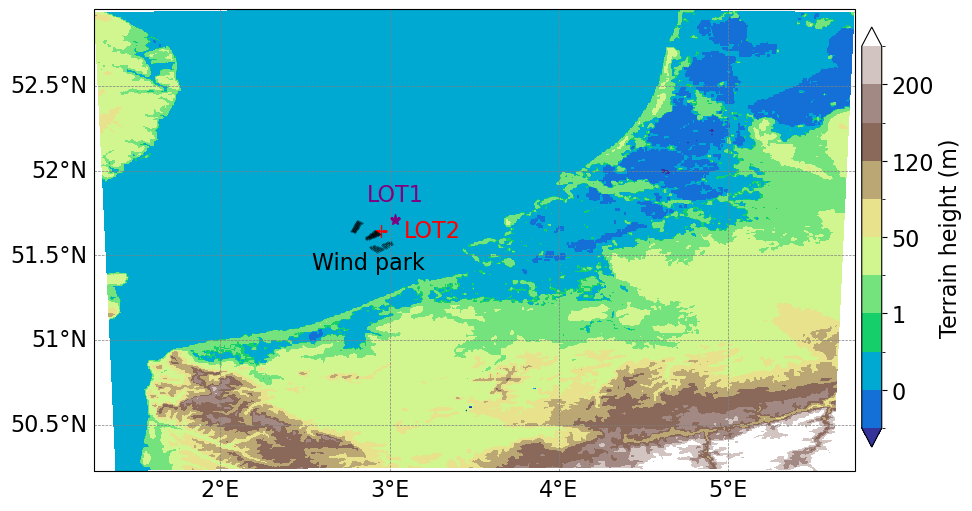

In [4]:
ds = xr.open_dataset(f'{root_dir}/run_7_geogrid/geo_em.d01.nc')
plot_data = ds.HGT_M[0, ...].assign_coords(latitude=ds.XLAT_M[0,...],longitude=ds.XLONG_M[0,...])

# Define the custom color levels and colormap
clevels = [-5, 0, 0.5, 1, 10, 50, 80, 120, 160, 200, 240]
cmap = plt.get_cmap("terrain")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 6),width_ratios=[1], subplot_kw={'projection':ccrs.PlateCarree()})

# Plot the data for the first file in the first subplot
im1 = plot_data.plot(x='longitude',y='latitude',levels=clevels, cmap=cmap, ax=axes,add_colorbar=False)
#cbar = plt.colorbar(im1, ax=axes[0], shrink=0.5)
#cbar.set_label('Terrain height (m)')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# Illustrate the observational points
label = 'LOT1'
lat, lon = buoy_locations[label]
axes.text(lon, lat + 0.15, label, color='purple', fontsize=16, ha='center', va='center')
marker = '*'
axes.plot(lon, lat, marker, markersize=8,color='purple')

label = 'LOT2'
lat, lon = buoy_locations[label]
axes.text(lon+0.3, lat, label, color='red', fontsize=16, ha='center', va='center')
marker = '+'
axes.plot(lon, lat, marker, markersize=8,color='red')

ds = xr.open_dataset(f'{root_dir}/borssele_wind_turbines.nc')
for i in range(len(ds.lon)):
    axes.plot(ds.lon[i], ds.lat[i], '.', markersize=0.5,color='black')
axes.text(ds.lon[50], ds.lat[50]-0.15, 'Wind park', color='black', fontsize=16, ha='center', va='center')

# Add colorbar spanning both subplots
cax = plt.axes([0.9, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label('Terrain height (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(f'{fig_dir}/Domain_terrain_height.png',dpi=300,bbox_inches='tight')

# Grid wind power time series

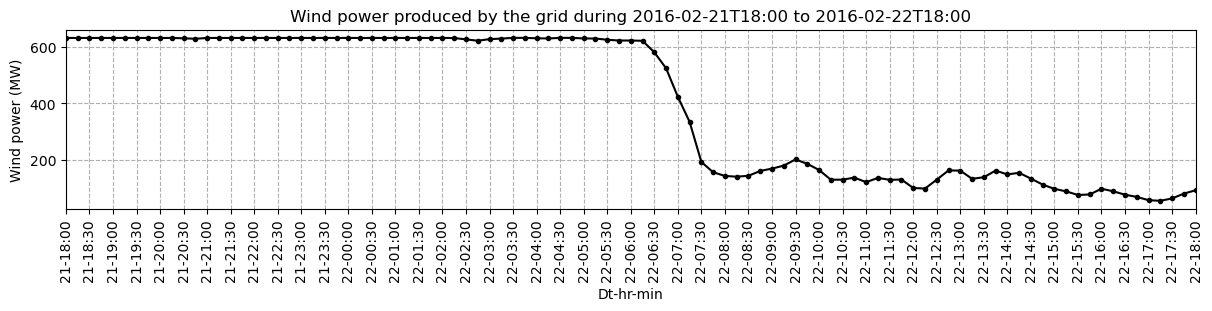

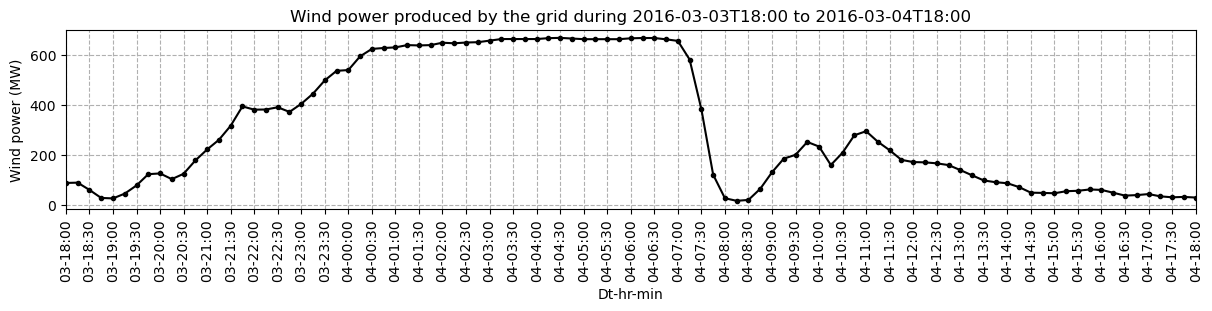

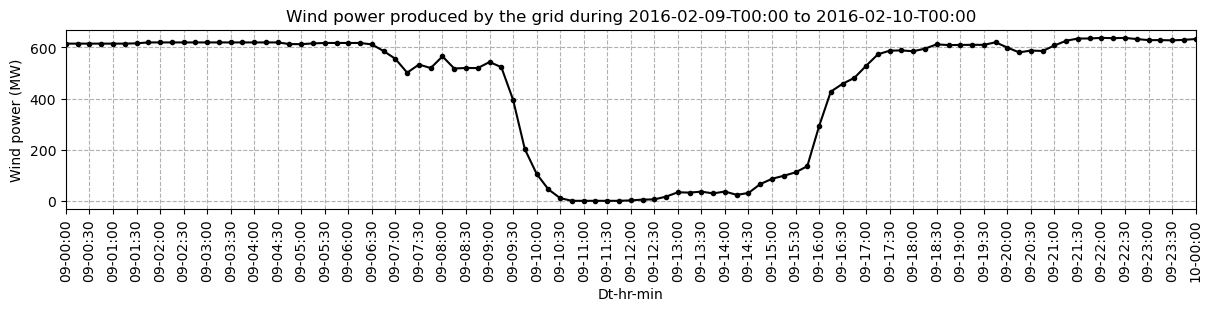

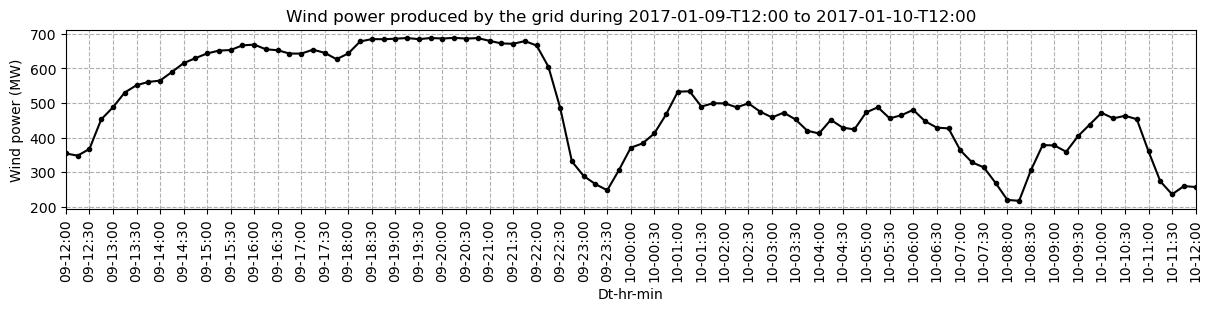

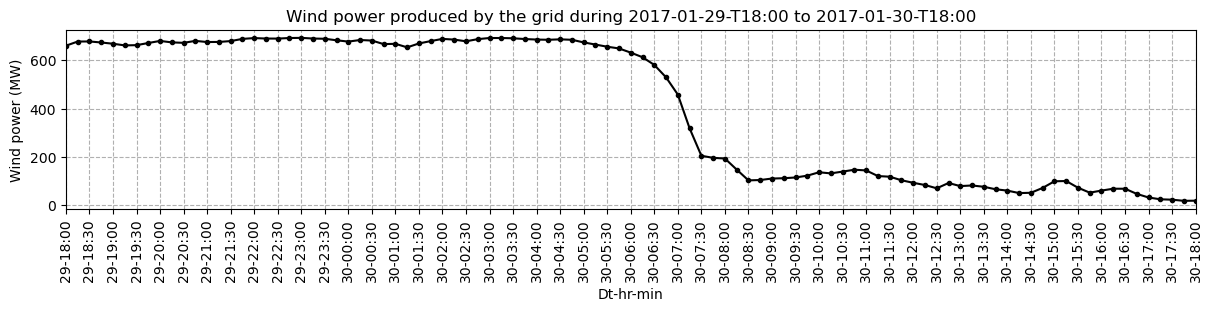

In [6]:
grid_power_file = f"{root_dir}/Elia_wind_power/Elia_wind_power.csv"
grid_power = pd.read_csv(grid_power_file, index_col=0)
grid_power = grid_power.rename_axis('times')
grid_power.index = pd.to_datetime(grid_power.index)
# Rename the first column to 'obs_power'
grid_power = grid_power.rename(columns={'Measured & upscaled [MW]': 'obs_power'})

for case in [1,2,3,4,5]:
    fig,ax = plt.subplots(1,1,figsize=(12, 3), layout='constrained')
    data  = grid_power.loc[event_periods[case-1][0]:event_periods[case-1][1],['obs_power']]
    index = data.index
    ax.plot(index,data,'.-',color='k')
    ax.set_title(f'Wind power produced by the grid during {event_periods[case-1][0]} to {event_periods[case-1][1]}')
    ax.set_ylabel('Wind power (MW)')
    ax.set_xlabel('Dt-hr-min')
    # Set x-axis tick labels in day-hr-min format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%da-%H-%M'))
    ax.set_xticks(index[::2])
    ax.set_xticklabels([dt.strftime('%d-%H:%M') for dt in index[::2]], rotation='vertical')
    ax.set_xlim(index[0],index[-1])
    ax.grid(linestyle='dashed')

    #---Saving the plot---#
    plt.savefig(f'{fig_dir}/Grid_power_timeseries_FLLJ_{case}.pdf',dpi=300,bbox_inches='tight',pad_inches=0.1)

# Time series of wind power

In [152]:
event_periods = [['2016-02-21T18:00','2016-02-22T18:00'],['2016-03-03T18:00','2016-03-04T18:00']]
ramp_periods = [['2016-02-22T00:00','2016-02-22T12:00'],['2016-03-04T00:00','2016-03-04T12:00']]

for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    '''
    The observed wind power at the grid are indeed stored at UTC.
    '''
    grid_power_file = f"{root_dir}/Elia_wind_power/Elia_wind_power.csv"
    grid_power = pd.read_csv(grid_power_file, index_col=0)
    #grid_power = grid_power.iloc[:-4,1:2] if case == 1 else grid_power.iloc[:-4,1:2]
    #grid_power.index = pd.date_range(start=event_periods[case-1][0], end=event_periods[case-1][1], freq='15T')
    grid_power = grid_power.rename_axis('times')
    grid_power.index = pd.to_datetime(grid_power.index)
    # Rename the first column to 'obs_power'
    grid_power = grid_power.rename(columns={'Measured & upscaled [MW]': 'obs_power'})
    grid_power = grid_power.loc[event_periods[case-1][0]:event_periods[case-1][1],['obs_power']]

    print(grid_power.head())
    for i,run in enumerate([1,2,3,4,5]):
        run_dir = f'WRF_run_{run}' # if run==1 or run==8 else f'WRF_run_{run+7}'
        files = glob.glob(f'{root_dir}/{case_dir}/{run_dir}/turbine_power.nc')
        ds = xr.open_dataset(files[0])
        # Check if 'power' exists in the dataset's variable names, otherwise check for 'POWER'
        var_name = 'power' if 'power' in ds else 'POWER'
        run_name = run_names[run-1]
        if case == 1 and run == 8:
            grid_power[run_name] = ds[var_name].values/1e6
        elif run == 3 or run == 4 or run == 6 or run == 7 or run == 15:
            grid_power[run_name] = ds[var_name].values[::3]/1e3 
        else:
            grid_power[run_name] = ds[var_name].values[::3]/1e6
    
    grid_power.to_csv(f'{root_dir}/{case_dir}/wind_power(3hCERRA).csv')

                     obs_power
times                         
2016-02-21 18:00:00     631.03
2016-02-21 18:15:00     631.03
2016-02-21 18:30:00     631.03
2016-02-21 18:45:00     631.03
2016-02-21 19:00:00     631.03
                     obs_power
times                         
2016-03-03 18:00:00      87.69
2016-03-03 18:15:00      88.86
2016-03-03 18:30:00      59.92
2016-03-03 18:45:00      27.77
2016-03-03 19:00:00      26.02


In [33]:
def plot_lines_timeseries(ax,index,data,color,marker,line,label,title,xlabel=None,ylabel=None,xticks=None,yticks=None,tick_interval=3):
    ax.plot(index,data,f'{marker}{line}',color=color,label=label,markersize=4)
    ax.set_title(title,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16) if ylabel else None
    ax.set_xlabel(xlabel,fontsize=16) if xlabel else None
    # set y-axis tick labels font size
    ax.tick_params(axis='y', labelsize=12)

    # get x-axis ticks at every 30 minutes
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%da-%H-%M'))
    minute_locator = MinuteLocator(interval=30)
    ax.xaxis.set_minor_locator(minute_locator)
    ax.set_xticks(index[::tick_interval])
    
    if xticks:
        # Set x-axis tick labels in day-hr-min format
        ax.set_xticklabels([dt.strftime('%d-%H:%M') for dt in index[::tick_interval]], rotation='vertical', fontsize=12)
    else:
        # dont set x ticks labels
        ax.set_xticklabels([])
    
    ax.set_xlim(index[0],index[-1])

    # set y-axis ticks
    if yticks is not None:
        ax.set_yticks(yticks)
    else:
        ax.set_yticks([])

    ax.grid(linestyle='dashed')
    return ax 

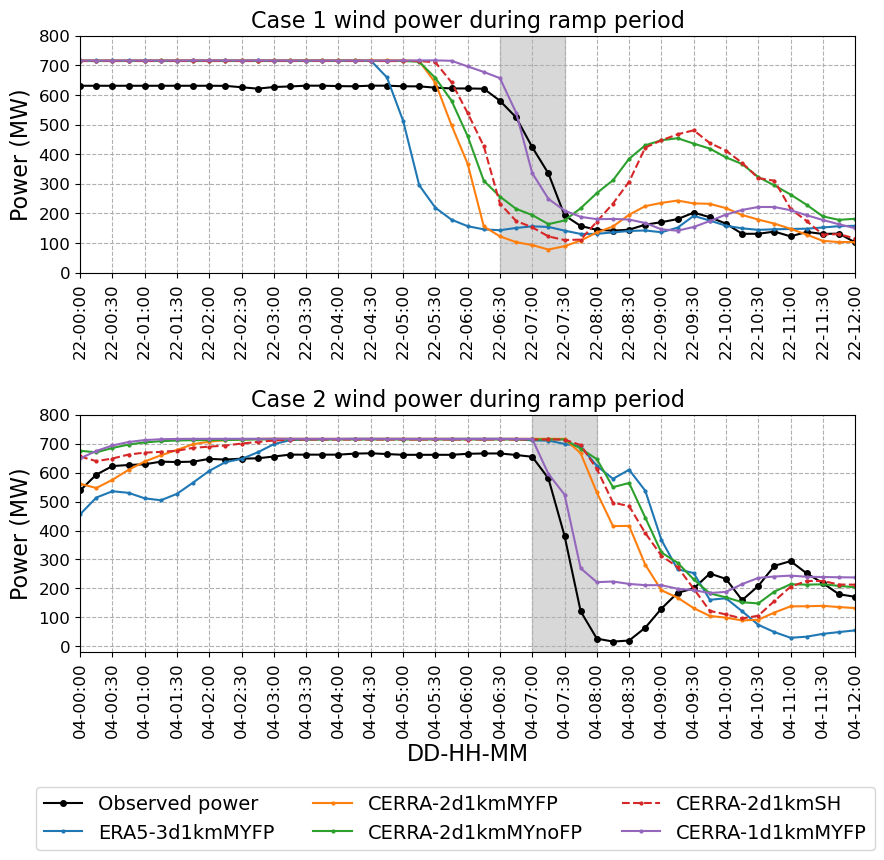

In [153]:
# create 10 custom colors, custom markers
ramp_durations = [['2016-02-22T06:30', '2016-02-22T07:30'],['2016-03-04T07:00', '2016-03-04T08:00']]
colors = sns.color_palette("tab10", 10)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','5']
linestyles = ['-','-','-','--','-','--','--','--']
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2,1,hspace=0.6)
for i,case in enumerate([1,2]):
    ax = fig.add_subplot(gs[i])
    xticks=True
    xlabel='DD-HH-MM' if i == 1 else None
    title = f'Case {case} wind power during ramp period'
    grid_power = pd.read_csv(f'{root_dir}/FLLJ_{case}/wind_power(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    for j,run in enumerate([1,2,3,4,5]):
        run_name = run_names[run-1]
        plot_lines_timeseries(ax,data.index,data[run_name],colors[j+1],'.',linestyles[j],run_name,title,
                              xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)
    
    # Add vertical shading for the specific ramp durations
    start_time = pd.to_datetime(ramp_durations[case - 1][0])
    end_time = pd.to_datetime(ramp_durations[case - 1][1])
    ax.axvspan(start_time, end_time, color='grey', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.15),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_power_timeseries(3hCERRA).pdf', dpi=300, bbox_inches='tight')

In [35]:
ramp_instances = {}
for case in [1,2]:
    ramp_instances[case] = {}
    my_list = []
    grid_power = pd.read_csv(f'{root_dir}/FLLJ_{case}/wind_power(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    times = pd.DataFrame(data.index)
    rated_power = 712.2
    obs_power = data[f'obs_power']
    cf_grid = obs_power/rated_power
    for j in [1,2,4]: #Loops through 15 min, 30min, and 1hr
        dmy = []
        del_cf_grid = np.array([(cf_grid.iloc[i+j]-cf_grid.iloc[i])*100 for i in range(len(cf_grid)-j)])
        dmy.append(round(np.min(del_cf_grid),1)*-1)
        dmy.append(times['times'].iloc[np.argmin(del_cf_grid)].strftime('%H:%M'))
        for run in [1,2,3,4,5]:
            label = run_names[run-1]
            wrf_power = data[f'{label}']
            cf_wrf = wrf_power/rated_power
            del_cf_wrf = np.array([(cf_wrf.iloc[i+j]-cf_wrf.iloc[i])*100 for i in range(len(cf_wrf)-j)])
            dmy.append(round(np.min(del_cf_wrf),1)*-1)
            dmy.append(times['times'].iloc[np.argmin(del_cf_wrf)].strftime('%H:%M'))
            if j == 4:
                ramp_instances[case][run] = times['times'].iloc[np.argmin(del_cf_wrf)].strftime('%Y-%m-%dT%H:%M')
        my_list.append(dmy)
    multiindex_tuples = []
    multiindex_tuples.append(('Grid_power', 'Delta_CF'))
    multiindex_tuples.append(('Grid_power', 'Time_instance'))
    for run in [1,2,3,4,5]:
        label = run_names[run-1]
        multiindex_tuples.append((label, 'Delta_CF'))
        multiindex_tuples.append((label, 'Time_instance'))
    columns = pd.MultiIndex.from_tuples(multiindex_tuples)
    index = ['15min','30min','1hr']
    df = pd.DataFrame(my_list,columns=columns,index=index)
    df.to_excel(f'{root_dir}/FLLJ_{case}/cf_ramp(3hCERRA).xlsx')
    print(df.head())

      Grid_power               ERA5-3d1kmMYFP               CERRA-2d1kmMYFP  \
        Delta_CF Time_instance       Delta_CF Time_instance        Delta_CF   
15min       19.9         07:15           30.6         05:00            29.7   
30min       32.3         07:00           51.2         04:45            48.0   
1hr         54.3         06:30           69.8         04:30            78.4   

                    CERRA-2d1kmMYnoFP               CERRA-2d1kmSH  \
      Time_instance          Delta_CF Time_instance      Delta_CF   
15min         06:00              21.1         06:00          27.2   
30min         05:45              38.0         05:45          43.0   
1hr           05:15              56.4         05:15          67.0   

                    CERRA-1d1kmMYFP                
      Time_instance        Delta_CF Time_instance  
15min         06:15            28.7         06:45  
30min         06:00            45.0         06:30  
1hr           05:30            62.8         06:30 

In [36]:
df

Grid_power               ERA5-3d1kmMYFP               CERRA-2d1kmMYFP  \
        Delta_CF Time_instance       Delta_CF Time_instance        Delta_CF   
15min       36.7         07:30           23.9         08:45            19.0   
30min       64.6         07:15           38.1         08:45            35.3   
1hr         88.2         07:00           52.9         08:45            54.1   

                    CERRA-2d1kmMYnoFP               CERRA-2d1kmSH  \
      Time_instance          Delta_CF Time_instance      Delta_CF   
15min         07:45              16.9         08:45          16.3   
30min         07:45              33.7         08:30          27.9   
1hr           07:45              46.8         08:30          42.7   

                    CERRA-1d1kmMYFP                
      Time_instance        Delta_CF Time_instance  
15min         08:00            35.8         07:30  
30min         07:45            45.8         07:15  
1hr           07:45            69.5         07:00

- CERRA-MYFP1d and CERRA-SH-0.5km1d are better in ramp statistics

# Spatial wind barbs

In [37]:
def plot_wind_barbs(fig, gs, u_data, v_data, XLONG, XLAT, n, title,contour_levels=None,normal_and_parallel=False,XLONG_line=None,XLAT_line=None,XLONG_nline=None,XLAT_nline=None,xlabel=None, ylabel=None):
    axs0 = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    
    # Calculate wind speed
    ws = wind_speed(u_data, v_data)
    
    # Create a colormap based on wind speed
    cmap = plt.get_cmap('tab20c')  # You can choose any colormap you prefer
    norm = mcolors.Normalize(vmin=contour_levels.min(), vmax=contour_levels.max())
    
    # Plot wind barbs
    barb_plot = axs0.barbs(XLONG[::n, ::n], 
                           XLAT[::n, ::n], 
                           u_data[::n, ::n], 
                           v_data[::n, ::n],
                           ws[::n, ::n], cmap=cmap, norm=norm,
                           length=5, transform=ccrs.PlateCarree())
    
    extent = [XLONG.min(), XLONG.max(), XLAT.min(), XLAT.max()]
    axs0.set_extent(extent, crs=ccrs.PlateCarree())

    # Set title and labels
    if title is not None:
        axs0.set_title(title, fontsize=16)

    if normal_and_parallel == 1:
        #Add cross section line
        axs0.plot(XLONG_line.values, XLAT_line.values, color='red', transform=ccrs.PlateCarree(), linewidth=1)
        #Add normal to the cross section line
        #axs0.plot(XLONG_nline.values, XLAT_nline.values, color='red', transform=ccrs.PlateCarree(), linewidth=1, linestyle='dashed')
        #Add A and B at the ends of the line
        axs0.text(XLONG_line.values[0], XLAT_line.values[0]+0.01, 'B', color='black', transform=ccrs.PlateCarree(), fontsize=12)
        axs0.text(XLONG_line.values[-1]-0.1, XLAT_line.values[-1]-0.3, 'A', color='black', transform=ccrs.PlateCarree(), fontsize=12)
    elif normal_and_parallel == 2:
        #Add cross section line
        axs0.plot(XLONG_line.values, XLAT_line.values, color='red', transform=ccrs.PlateCarree(), linewidth=1)
        #Add normal to the cross section line
        #axs0.plot(XLONG_nline.values, XLAT_nline.values, color='red', transform=ccrs.PlateCarree(), linewidth=1, linestyle='dashed')
        axs0.text(XLONG_line.values[0], XLAT_line.values[0]+0.01, 'A', color='black', transform=ccrs.PlateCarree(), fontsize=12)
        axs0.text(XLONG_line.values[-1]-0.1, XLAT_line.values[-1]-0.3, 'B', color='black', transform=ccrs.PlateCarree(), fontsize=12)
    
    # Add the observational location
    axs0.scatter(buoy_locations['LOT1'][1],buoy_locations['LOT1'][0], color='black', marker='*', transform=ccrs.PlateCarree(), s=50)
    axs0.scatter(buoy_locations['LOT2'][1],buoy_locations['LOT2'][0], color='black', marker='*', transform=ccrs.PlateCarree(), s=50)

    # Add coastlines and gridlines
    axs0.coastlines()
    
    # Adjust the placement of gridline labels
    gl = axs0.gridlines(draw_labels=True)
    gl.top_labels = False  # Disable top labels for latitude
    gl.right_labels = False  # Disable right labels for longitude

    # cartopy fails to add the xlabel and label
    if ylabel is not None:
        axs0.text(-0.25, 0.55, ylabel, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axs0.transAxes, fontsize=12)
    
    return barb_plot

In [38]:
def compute_normal_parallel(u_cross, v_cross, angle_degrees):
    '''
    Takes u and v components, and computes tangent and normal components at an angle
    returns transact normal and transact parallel components, which are indeed front parallel and front normal components
    '''
    angle_radians = np.radians(angle_degrees)
    normal_vector = np.array([np.cos(angle_radians), np.sin(angle_radians)])
    parallel_vector = np.array([-np.sin(angle_radians), np.cos(angle_radians)])
    
    # Calculate the tangent and normal components
    transact_normal_component = u_cross * normal_vector[0] + v_cross * normal_vector[1]
    transact_parallel_component = -(u_cross * parallel_vector[0] + v_cross * parallel_vector[1])
    
    return transact_normal_component, transact_parallel_component

def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Computes the distance between two points
    If the 2nd point is a list, then computes the distance in positive, 0 , negative order, relative to the 1st point
    Since the line is calculated from bottom to top, but we want to present in top-to-bottom direction.
    Thus, assign positive distance before observation and negative after, while moving from bottom-to-top
    '''
    R = 6371000  # Earth radius in meters

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    distance = distance/1000.0 #converting into km

    return distance

In [162]:
def get_normal_paralel_XLONG_XLAT_u_v(root_dir,case_dir,run,run_dir,time_instance, level,angle):

    u_data, v_data, XLONG, XLAT = extract_u_v(root_dir, case_dir,run,run_dir,time_instance,levels=[1100.0])
    u_data = u_data.squeeze()
    v_data = v_data.squeeze()

    ind_y,ind_x = find_nearest_indice(XLAT, XLONG, buoy_locations['LOT2'][0],buoy_locations['LOT2'][1])
    pivot_point = CoordPair(ind_x,ind_y)

    # Interpolate XLAT and XLONG at the cross-sectional line, using pivot point and angle
    XLAT_line = interpline(XLAT, pivot_point=pivot_point, angle=angle,latlon=True)
    XLONG_line = interpline(XLONG, pivot_point=pivot_point, angle=angle,latlon=True)

    # Interpolate XLAT and XLONG normal to the cross-sectional line, using pivot point and angle
    XLAT_nline = interpline(XLAT, pivot_point=pivot_point, angle=angle-90,latlon=True)
    XLONG_nline = interpline(XLONG, pivot_point=pivot_point, angle=angle-90,latlon=True)

    # Get the line distance relative to LOT1_loc across cross-sectional line
    distances = haversine_distance(buoy_locations['LOT1'][0],buoy_locations['LOT1'][1], XLAT_line, XLONG_line)
    # Find the index of the minimum distance
    argmin_index = int(distances.argmin())

    # Create an array of adjusted distances
    line_distances = np.empty_like(distances)
    if case_dir == 'FLLJ_1':
        line_distances[:argmin_index] = distances[:argmin_index]
        line_distances[argmin_index:] = -distances[argmin_index:]
    else:
        line_distances[:argmin_index] = -distances[:argmin_index]
        line_distances[argmin_index:] = distances[argmin_index:]

    # Interpolate u and v at the cross-sectional line, using pivot point and angle
    u_cross = interpline(u_data, pivot_point=pivot_point, angle=angle, latlon=True)
    v_cross = interpline(v_data, pivot_point=pivot_point, angle=angle, latlon=True)

    # Assign line distances coordinates to to u and v cross-sections
    u_cross = u_cross.assign_coords(line_idx=line_distances)
    v_cross = v_cross.assign_coords(line_idx=line_distances)

    # Get the tangent and normal components for the cross-sectional line
    normal_component,parallel_component = compute_normal_parallel(u_cross, v_cross, angle-180)

    return u_data, v_data, XLAT, XLONG, XLAT_line, XLONG_line, XLAT_nline, XLONG_nline, line_distances, normal_component, parallel_component

In [163]:
def plot_cross_section(fig, gs, data, line_distances, title, xlabel, ylabel, contour_levels=None,cmap=None,case=None):
    ax = fig.add_subplot(gs)
    c_levels = contour_levels
    cmap = plt.get_cmap(cmap)  # You can choose any colormap you prefer
    norm = mcolors.Normalize(vmin=c_levels.min(), vmax=c_levels.max())
    contourf1 = data.plot.contourf(ax=ax,levels=c_levels, cmap=cmap,norm=norm, extend='both',add_colorbar=False)
    ax.set_yticks(data.num_z_levels_stag.values)

    ax.set_ylim(10, 1100)
    ax.set_yticks([10,100,200,500,700,900,1100])
    ax.set_xlabel(xlabel, fontsize=16) if xlabel is not None else ax.set_xlabel('')
    ax.set_ylabel(ylabel, fontsize=16) if ylabel is not None else ax.set_ylabel('')
    ax.set_title(title,fontsize=16) if title is not None else ax.set_title('')

    # Add labels "A" and "B"
    if case == 1:
        ax.text(line_distances[0]-15, 0, 'B', color='black', fontsize=14)
        ax.text(line_distances[-1], 0, 'A', color='black', fontsize=14)
    else:
        ax.text(line_distances[0], 0, 'A', color='black', fontsize=14)
        ax.text(line_distances[-1]-15, 0, 'B', color='black', fontsize=14)

    return contourf1

Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)


Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)


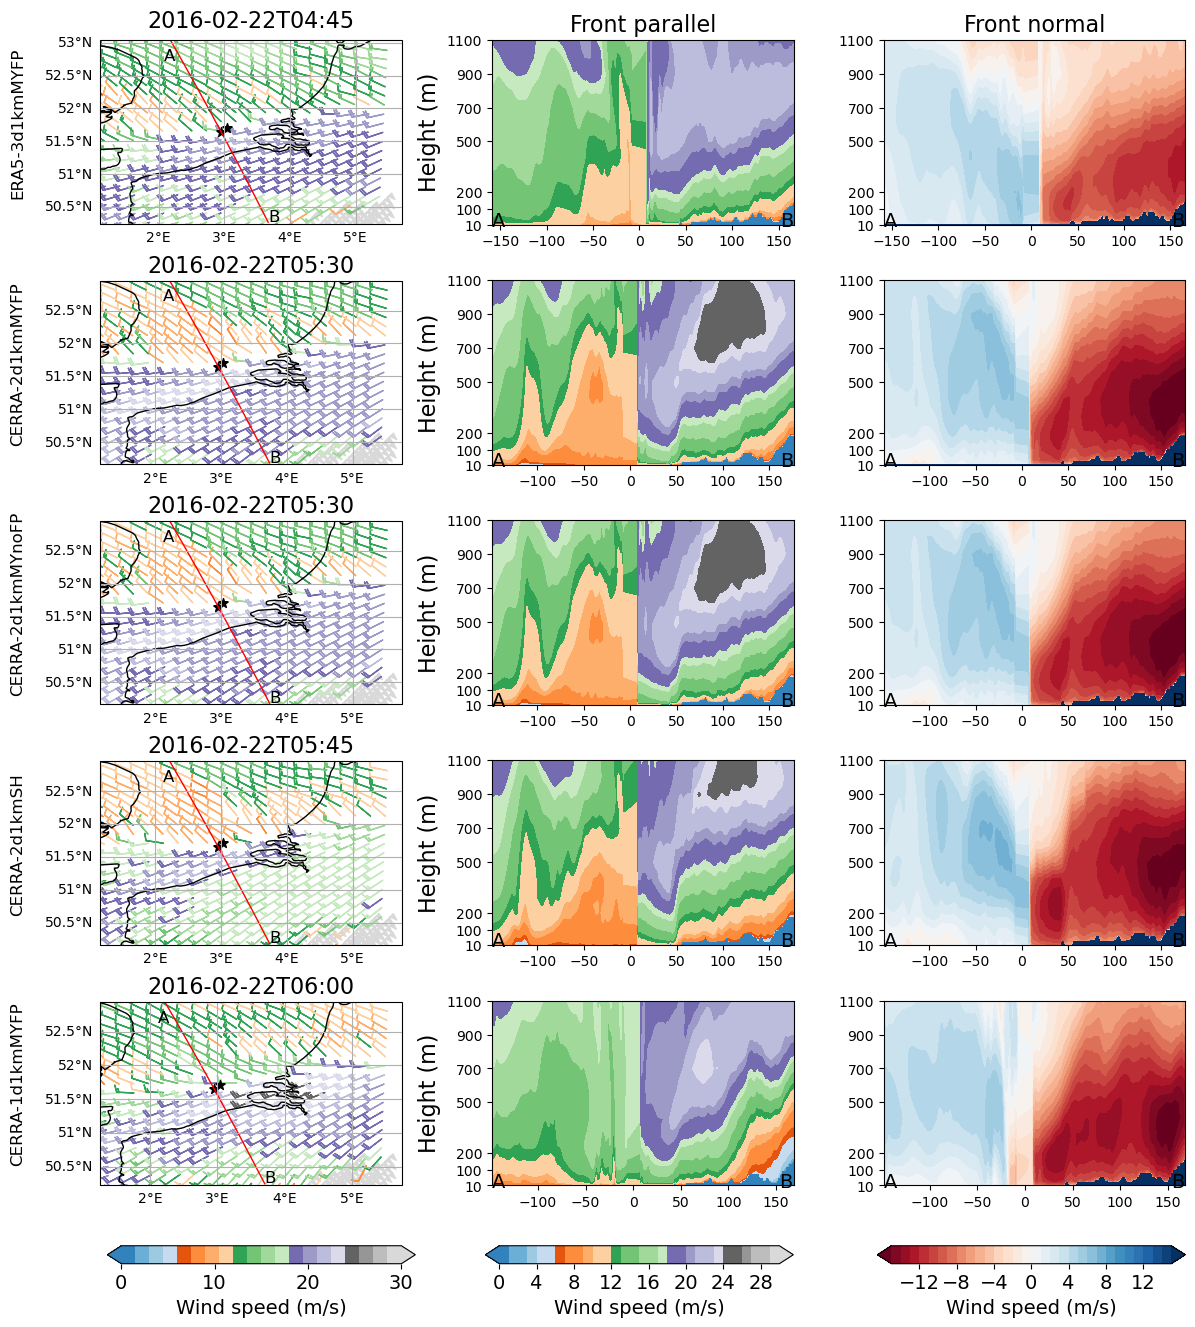

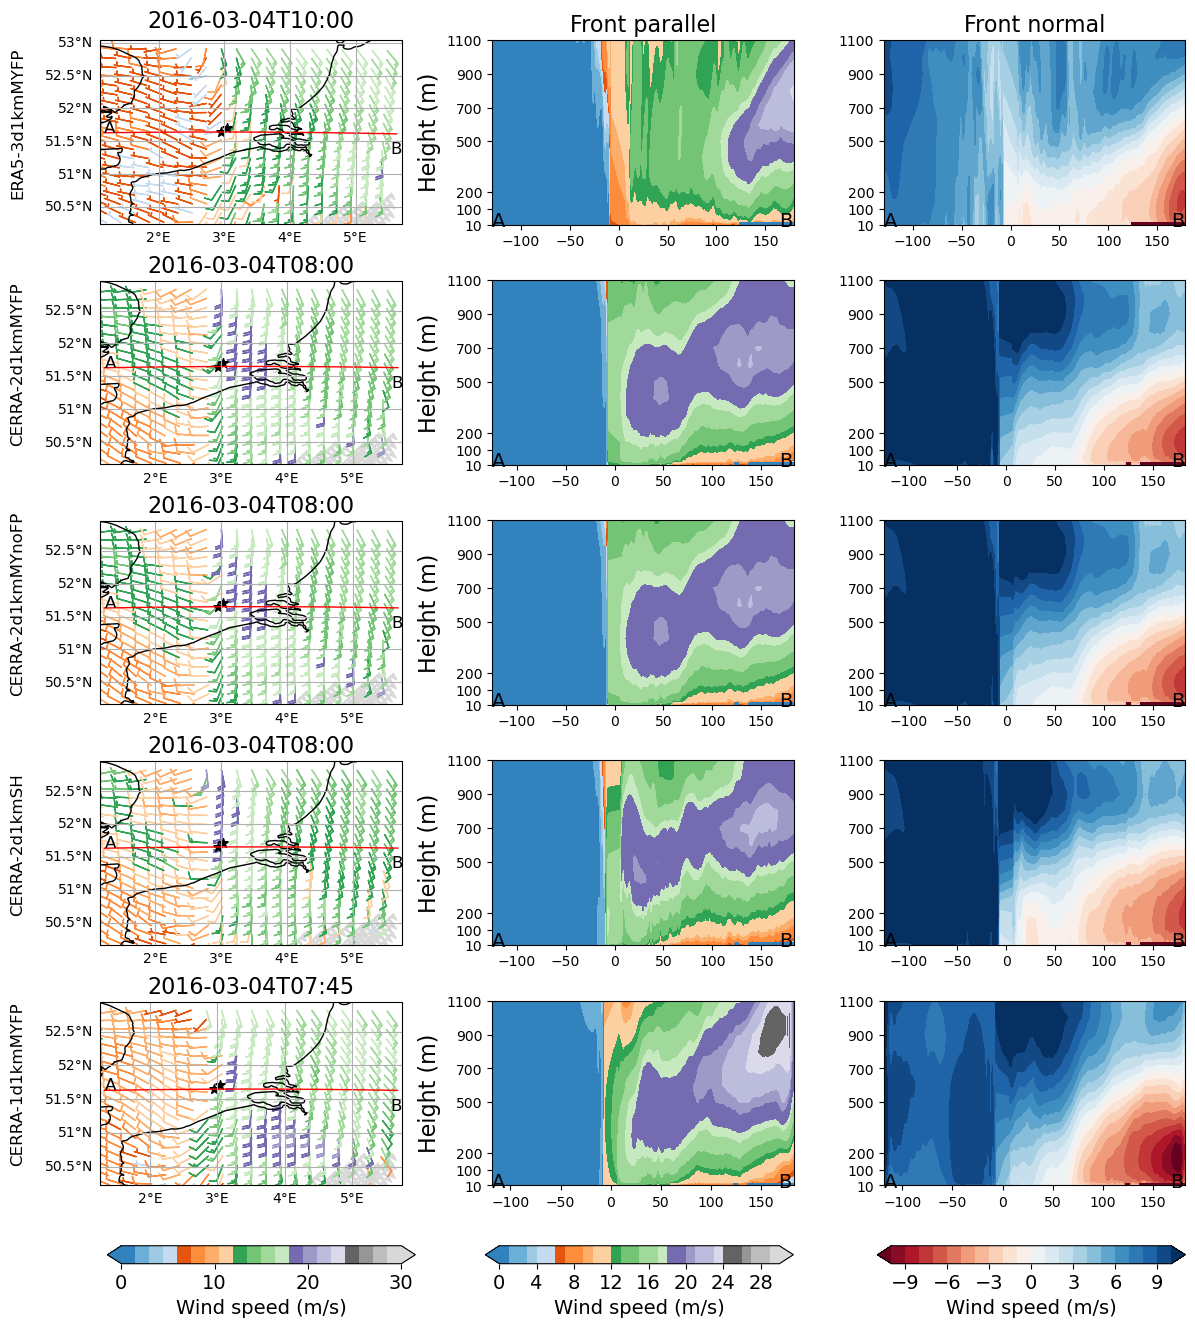

In [203]:
angles = [165,270]
time_instances = [['2016-02-22T04:45','2016-02-22T05:30','2016-02-22T05:30','2016-02-22T05:45','2016-02-22T06:00'],
                  ['2016-03-04T10:00','2016-03-04T08:00','2016-03-04T08:00','2016-03-04T08:00','2016-03-04T07:45']]
for case in [1,2]:
    case_dir = f'FLLJ_{case}' 
    fig = plt.figure(figsize=(14, 18))
    gs = plt.GridSpec(6,3,width_ratios=[1,1,1],height_ratios=[1,1,1,1,1,1],hspace=0.3,wspace=0.3)
    angle = angles[case-1]

    for i,run in enumerate([1,2,3,4,5]):
        run_dir = f'WRF_run_{run}' # if run==1 else f'WRF_run_{run+7}'
        u_data, v_data, XLAT, XLONG, XLAT_line, XLONG_line, XLAT_nline, XLONG_nline, line_distances, normal_component, parallel_component = get_normal_paralel_XLONG_XLAT_u_v(root_dir,case_dir,run,run_dir,time_instances[case-1][i],[1100.0], angle)
        # == First figure - wind barbs ==##
        n = 30  if run == 6 or run == 7 else 15
        title = time_instances[case-1][i]
        ylabel = run_names[run-1]
        ax0 = plot_wind_barbs(fig, gs[i,0], u_data.sel(num_z_levels_stag=200.), v_data.sel(num_z_levels_stag=200.), XLONG, XLAT,n,title,contour_levels[case-1][0],
        normal_and_parallel=case,XLONG_line=XLONG_line,XLAT_line=XLAT_line,XLONG_nline=XLONG_nline,XLAT_nline=XLAT_nline,ylabel=ylabel)

        # == Second figure - normal component ==##
        data = normal_component
        title = 'Front parallel' if run == 1 else None
        ylabel = 'Height (m)'
        ax1 = plot_cross_section(fig, gs[i,1], data, line_distances, title, None, ylabel, contour_levels=contour_levels[case-1][1],cmap='tab20c',case=case)

        # == Third figure - parallel component ==##
        data = parallel_component
        title = 'Front normal' if run == 1 else None
        ylabel = None
        ax2 = plot_cross_section(fig, gs[i,2], data, line_distances, title, None, ylabel, contour_levels=contour_levels[case-1][2],cmap='RdBu',case=case)

    # Adding colorbar for column 1 figures
    cbarb_ax = fig.add_axes([0.13, 0.2, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax0, cax=cbarb_ax, orientation='horizontal',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    cbarb_ax = fig.add_axes([0.4, 0.2, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax1, cax=cbarb_ax, orientation='horizontal',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    cbarb_ax = fig.add_axes([0.68, 0.2, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax2, cax=cbarb_ax, orientation='horizontal',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    # save figure
    plt.savefig(f'{fig_dir}/FLLJ_{case}_cross_section(3hCERRA).pdf', dpi=300, bbox_inches='tight')

FLLJ_1
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)


FLLJ_2
Closest indices in the order of latitude (y) and longitude (x) are : (161, 118)


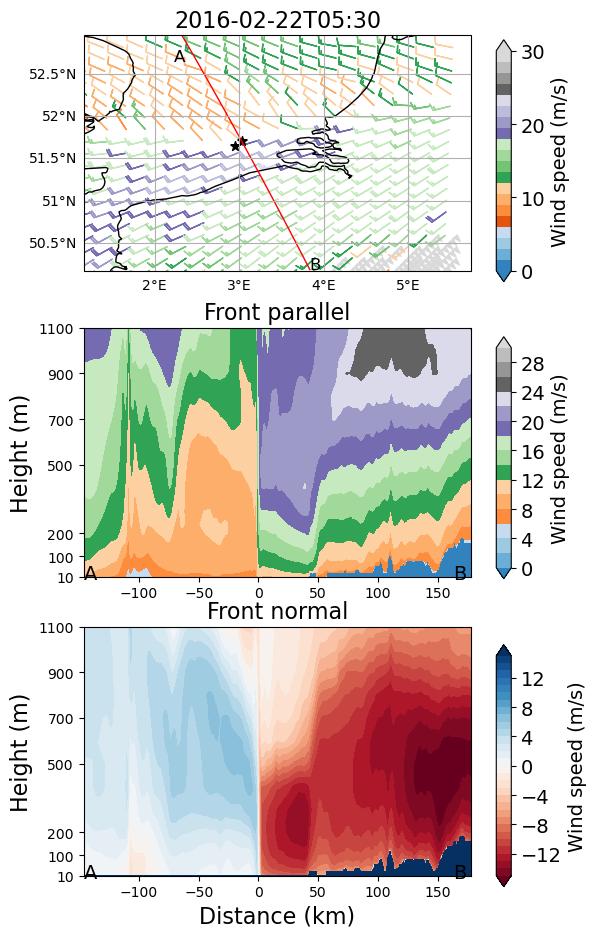

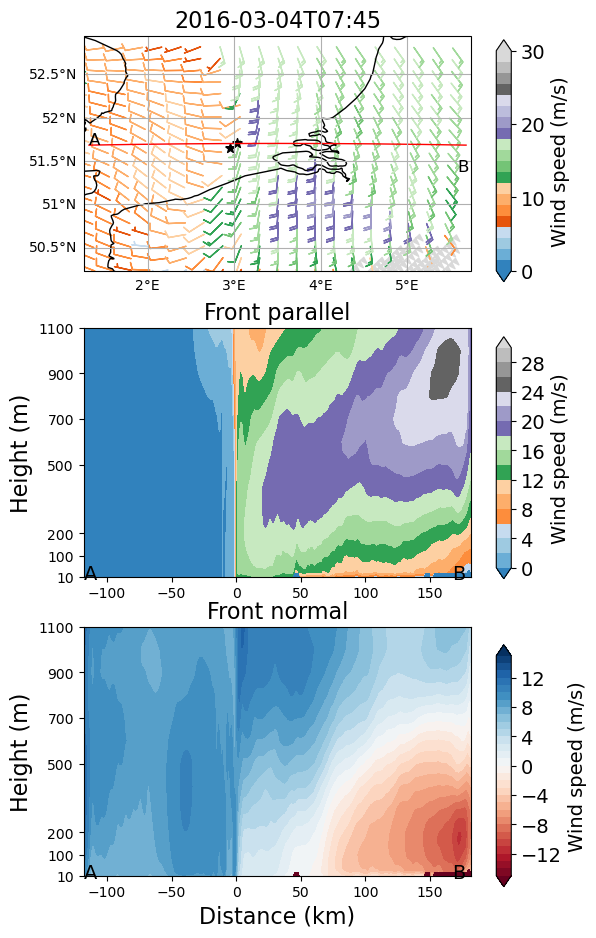

In [28]:
time_instances = ['2016-02-22T05:30','2016-03-04T07:45']
angles = [165,270]
for case, run in [(1,4),(2,5)]:
    case_dir = f'FLLJ_{case}' 
    print(case_dir)
    fig = plt.figure(figsize=(5, 11))
    gs = plt.GridSpec(3,1)
    angle = angles[case-1]

    run_dir = f'WRF_run_{run}' # if run==1 else f'WRF_run_{run+7}'
    u_data, v_data, XLAT, XLONG, XLAT_line, XLONG_line, XLAT_nline, XLONG_nline, line_distances, normal_component, parallel_component = get_normal_paralel_XLONG_XLAT_u_v(root_dir,case_dir,run,run_dir,time_instances[case-1],[1100.0], angle)
    # == First figure - wind barbs ==##
    n = 30  if run == 6 or run == 7 else 15
    title = time_instances[case-1]
    ylabel = None #run_names[run-1]
    ax0 = plot_wind_barbs(fig, gs[0,0], u_data.sel(num_z_levels_stag=200.), v_data.sel(num_z_levels_stag=200.), XLONG, XLAT,n,title,contour_levels[case-1],
    normal_and_parallel=case,XLONG_line=XLONG_line,XLAT_line=XLAT_line,XLONG_nline=XLONG_nline,XLAT_nline=XLAT_nline,ylabel=ylabel)
    # Adding colorbar for column 1 figures
    cbarb_ax = fig.add_axes([0.95, 0.65, 0.03, 0.22])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax0, cax=cbarb_ax, orientation='vertical',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.yaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='y', labelsize=14)

    # == Second figure - normal component ==##
    data = normal_component
    title = 'Front parallel'# if run == 1 else None
    xlabel = 'Distance (km)' 
    ylabel = 'Height (m)'
    ax1 = plot_cross_section(fig, gs[1,0], data, line_distances, title, None, ylabel, contour_levels=np.arange(0, 31,2),cmap='tab20c',case=case)
    # Adding colorbar for column 1 figures
    cbarb_ax = fig.add_axes([0.95, 0.38, 0.03, 0.22])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax1, cax=cbarb_ax, orientation='vertical',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.yaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='y', labelsize=14)

    # == Third figure - parallel component ==##
    data = parallel_component
    title = 'Front normal'# if run == 1 else None
    ax2 = plot_cross_section(fig, gs[2,0], data, line_distances, title, xlabel, ylabel, contour_levels=np.arange(-15, 16, 1),cmap='RdBu',case=case)
    # Adding colorbar for column 1 figures
    cbarb_ax = fig.add_axes([0.95, 0.1, 0.03, 0.22])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax2, cax=cbarb_ax, orientation='vertical',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.yaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='y', labelsize=14)
    
    # save figure
    plt.savefig(f'{fig_dir}/FLLJ_{case}_{run_names[run-1]}_cross_section_during_{time_instances[case-1]}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

# Time series of wind speed

In [154]:
obs_levels = [30,40,60,100,120,160,200] #the first level, 4 m is excluded
def obs_ws_wdir(start_time,end_time,levels,location):
    df = pd.read_csv(f'{root_dir}/LIDARS/{location}_WindResourceSpeedDirectionTIStat.csv',index_col=0)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.loc[start_time:end_time]
    ws = {}
    wdir = {}
    for level in levels:
        if (level==4):
            ws[float(level)] = df.loc[start_time:end_time,f'WindSpeed{level:03d}m m/s']
            wdir[float(level)] = df.loc[start_time:end_time,f'WindDir{level:03d}m deg']
        else:
            ws[float(level)] = df.loc[start_time:end_time,f'WindSpeed{level:03d}mh m/s']
            wdir[float(level)] = df.loc[start_time:end_time,f'WindDir{level:03d}m deg']
    ws = pd.DataFrame(ws)
    wdir = pd.DataFrame(wdir)
    return ws,wdir

## Extract wind speed and direction data and save to a dataframe dictonary

In [155]:
ws_dict = {}
wdir_dict = {}
for case in [1,2]:
    ws_dict[case] = {}
    case_dir = f'FLLJ_{case}'
    ws_dfs = {}
    wdir_dict[case] = {}
    wdir_dfs = {}
    for location in ['LOT1','LOT2']:
        ws_dfs[location] = []
        wdir_dfs[location] = []
        # observations
        obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],obs_levels,location)
        ws_dfs[location].append(obs_ws)
        wdir_dfs[location].append(obs_wdir)
        # simulations
        for run in [1,2,3,4,5]:
            run_dir = f'WRF_run_{run}' # if run==1 else f'WRF_run_{run+7}'
            u,v,_,_= extract_u_v(root_dir, case_dir,run,run_dir,dates_range=ramp_periods[case-1],levels=[30,1100],location=buoy_locations[location])
            ws = wind_speed(u,v).drop_vars({'XLAT','XLONG'}).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='ws')
            ws_dfs[location].append(ws)
            wdir = wind_direction(u,v).drop_vars({'XLAT','XLONG'}).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='wdir')
            wdir_dfs[location].append(wdir)
    ws_dict[case] = ws_dfs
    wdir_dict[case] = wdir_dfs

Closest indices in the order of latitude (y) and longitude (x) are : (155, 126)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (161, 118)
Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 126)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude

for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    ws_dfs = ws_dict[case]
    for location in ['LOT1','LOT2']:
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Blues", len(obs_levels))
        fig = plt.figure(figsize=(12, 10))
        gs = plt.GridSpec(4,2,hspace=0.4, wspace=0.1)

        # observations
        obs_ws = ws_dfs[location][0]
        ax = fig.add_subplot(gs[0,0])
        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel='m/s',xticks=False,yticks=np.arange(5, 25.1, 5))
        j = 1
        for run in [1,2,3,4,5,6,7]:
            run_dir = f'WRF_run_{run}'
            ws = ws_dfs[location][run]
            ax = fig.add_subplot(gs[(j)//2,(j)%2])
            xlabel = 'DD-HH-MM' if j//2 == 3 else None
            ylabel = 'm/s' if j%2 == 0 else None
            xticks = True if j//2 == 3 else False
            for i,level in enumerate(obs_levels):
                plot_lines_timeseries(ax,ws.index[::2],ws[level][::2],colors[i],'.','-',f'{level} m',run_names[run-1],
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 5))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.05),fontsize=14)
        plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_speed_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

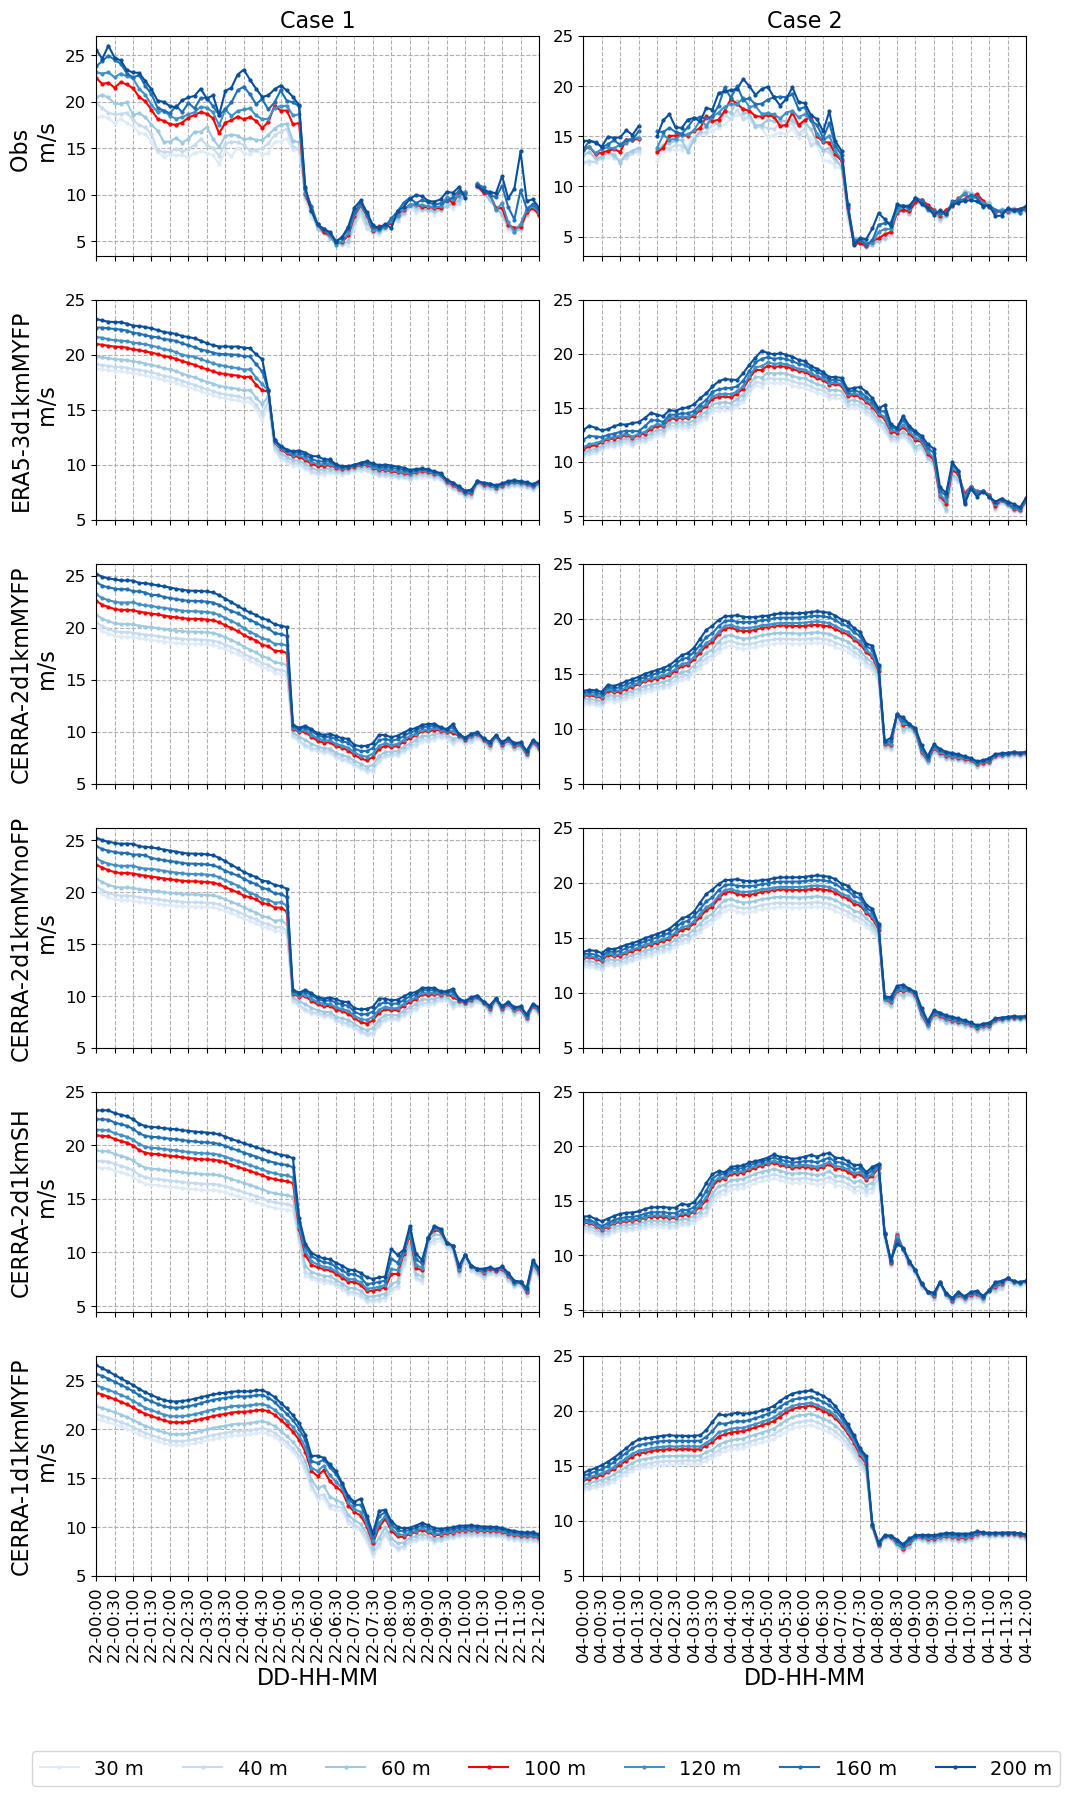

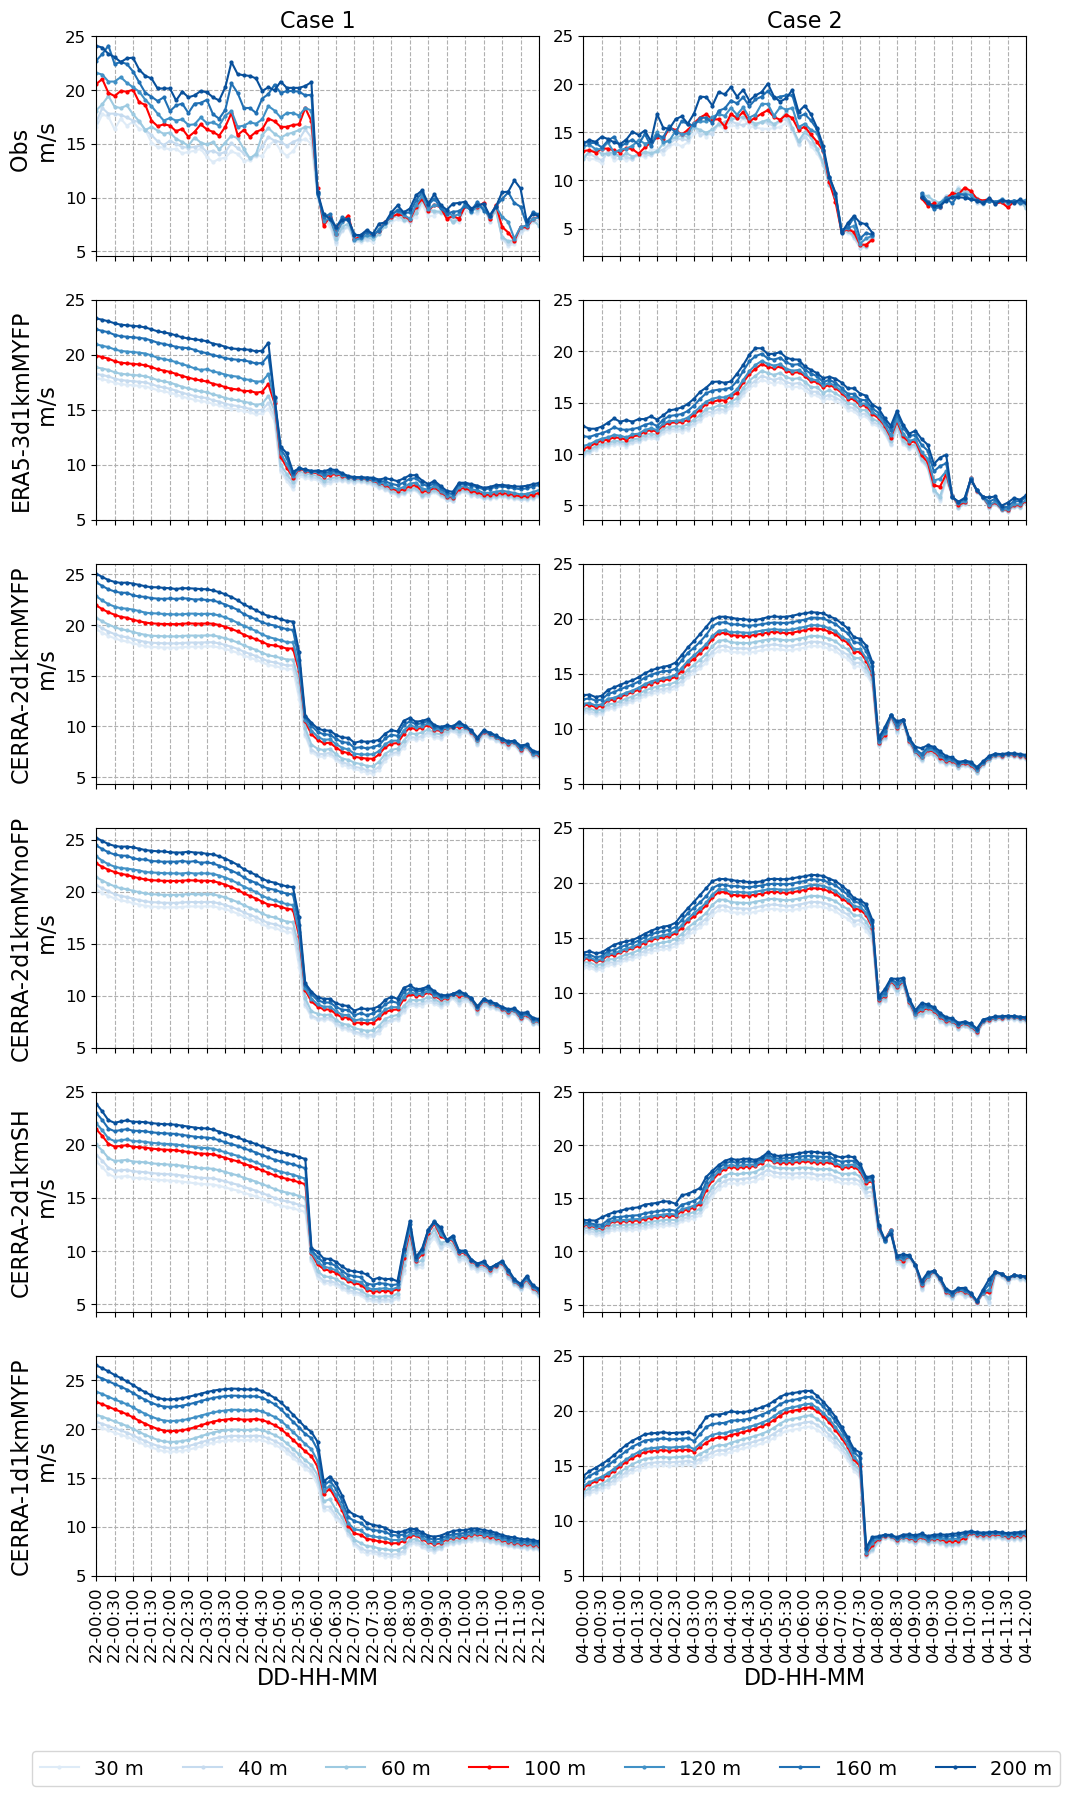

In [156]:
for location in ['LOT1','LOT2']:
    fig = plt.figure(figsize=(12, 20))
    gs = plt.GridSpec(6,2,hspace=0.2, wspace=0.1)
    for k,case in enumerate([1,2]):

        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Blues", len(obs_levels))

        # observations
        obs_ws = ws_dfs[location][0]
        j = 0
        ylabel = f'Obs \n m/s' if k == 0 else False
        ax = fig.add_subplot(gs[j,k])
        for i,level in enumerate(obs_levels):
            color = 'red' if level == 100. else colors[i]
            plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],color,'.','-',f'{level} m',f'Case {case}',
                                xlabel=None,ylabel=ylabel,xticks=False,yticks=np.arange(5, 25.1, 5))
        j = 1
        for run in [1,2,3,4,5]:
            run_dir = f'WRF_run_{run}'
            ws = ws_dfs[location][j]
            run_name = run_names[run-1]
            ax = fig.add_subplot(gs[j,k])
            xlabel = 'DD-HH-MM' if j == 5 else None
            ylabel = f'{run_name}\n m/s' if k == 0 else None
            xticks = True if j == 5 else False
            for i,level in enumerate(obs_levels):
                color = 'red' if level == 100. else colors[i]
                plot_lines_timeseries(ax,ws.index[::2],ws[level][::2],color,'.','-',f'{level} m','',
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 5))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,0.0),fontsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_speed_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    wdir_dfs = wdir_dict[case]
    for location in ['LOT1','LOT2']:
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Greens", len(obs_levels))
        fig = plt.figure(figsize=(12, 10))
        gs = plt.GridSpec(4,2,hspace=0.4, wspace=0.1)

        # observations
        obs_wdir = wdir_dfs[location][0]
        ax = fig.add_subplot(gs[0,0])
        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_wdir.index,obs_wdir[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel='deg',xticks=False,yticks=np.arange(210, 360.1, 30))
        j = 1
        for run in range(1,8):
            run_dir = f'WRF_run_{run}'
            wdir = wdir_dfs[location][run]
            ax = fig.add_subplot(gs[(j)//2,(j)%2])
            xlabel = 'DD-HH-MM' if j//2 == 3 else None
            ylabel = 'deg' if j%2 == 0 else None
            xticks = True if j//2 == 3 else False
            for i,level in enumerate(obs_levels):
                plot_lines_timeseries(ax,wdir.index[::2],wdir[level][::2],colors[i],'.','-',f'{level} m',run_names[run-1],
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(210, 360.1, 30))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.05),fontsize=14)
        plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_direction_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

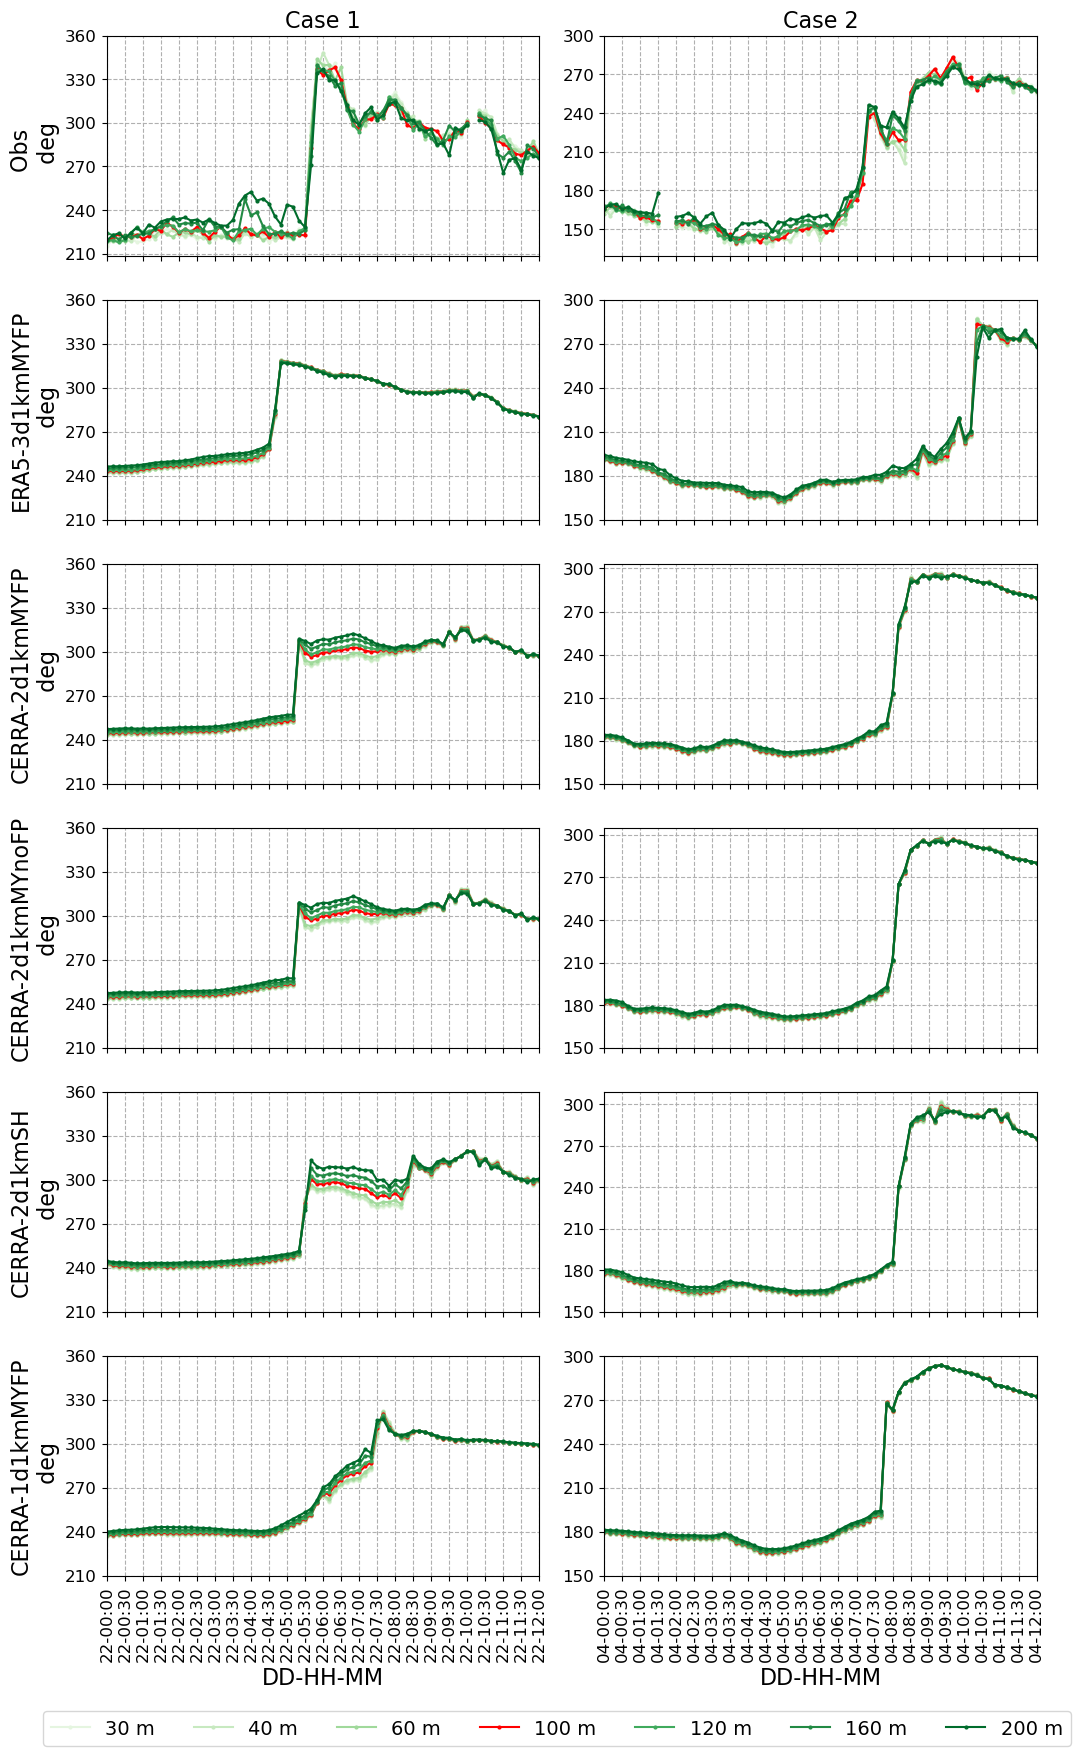

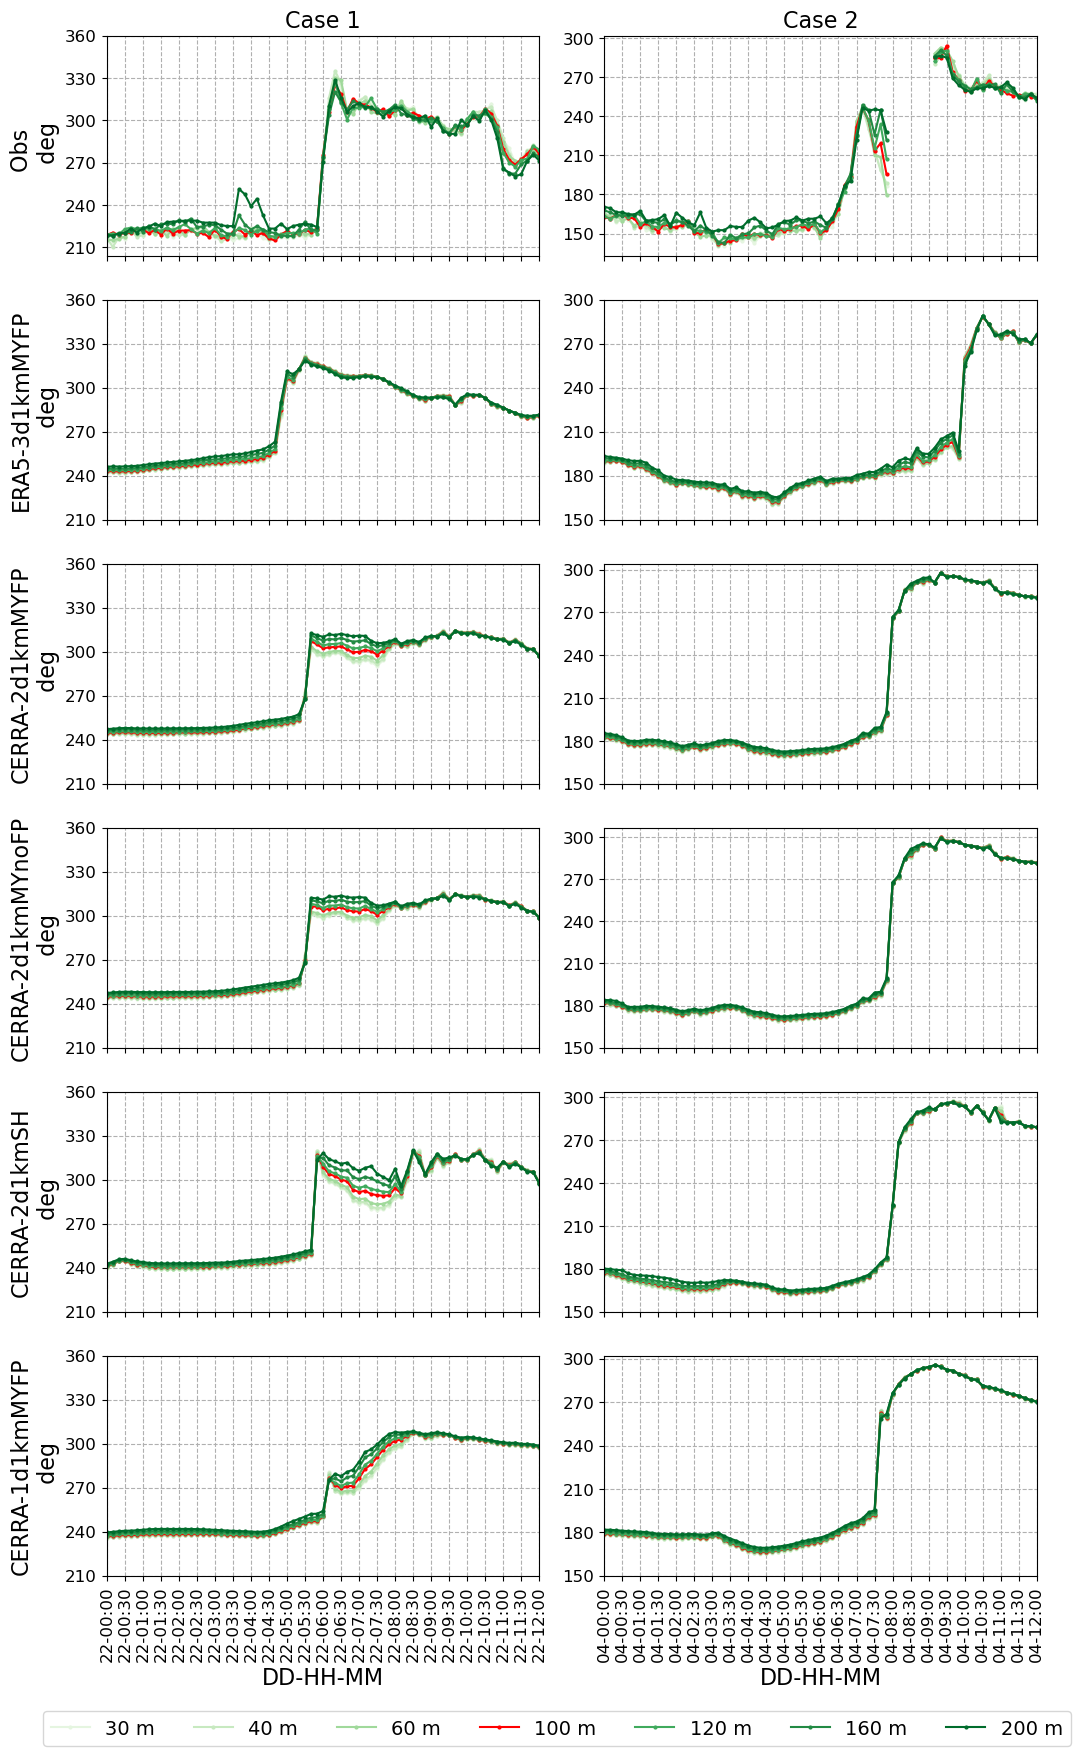

In [157]:
wdir_ticks = [np.arange(210, 360.1, 30),np.arange(150, 300.1, 30)]
for location in ['LOT1','LOT2']:
    fig = plt.figure(figsize=(12, 20))
    gs = plt.GridSpec(6,2,hspace=0.2, wspace=0.15)
    for k,case in enumerate([1,2]):

        case_dir = f'FLLJ_{case}'
        wdir_dfs = wdir_dict[case]
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Greens", len(obs_levels))

        # observations
        obs_wdir = wdir_dfs[location][0]
        j = 0
        ylabel = f'Obs \n deg' if k == 0 else False
        ax = fig.add_subplot(gs[j,k])
        for i,level in enumerate(obs_levels):
            color = 'red' if level == 100. else colors[i]
            plot_lines_timeseries(ax,obs_wdir.index,obs_wdir[level],color,'.','-',f'{level} m',f'Case {case}',
                                xlabel=None,ylabel=ylabel,xticks=False,yticks=wdir_ticks[k])
        j = 1
        for run in [1,2,3,4,5]:
            run_dir = f'WRF_run_{run}'
            wdir = wdir_dfs[location][j]
            ax = fig.add_subplot(gs[j,k])
            xlabel = 'DD-HH-MM' if j == 5 else None
            ylabel = f'{run_names[run-1]}\n deg' if k == 0 else None
            xticks = True if j == 5 else False
            for i,level in enumerate(obs_levels):
                color = 'red' if level == 100. else colors[i]
                plot_lines_timeseries(ax,wdir.index[::2],wdir[level][::2],color,'.','-',f'{level} m','',
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=wdir_ticks[k])
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,0.02),fontsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_direction_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

## Wind speed time-height cross sections

In [224]:
def plot_time_height_crosssection(ax,index,columns,data,levels,cmap,title,xlabel=None,ylabel=None,xticks=None,yticks=None,tick_interval=3,jet_heights=None):
    contour = ax.contourf(index,columns,data,levels=levels,cmap=cmap,extend='both')
    ax.set_title(title,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16) if ylabel else None
    ax.set_xlabel(xlabel,fontsize=16) if xlabel else None
    # set y-axis tick labels font size
    ax.tick_params(axis='y', labelsize=12)

    # get x-axis ticks at every 30 minutes
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%da-%H-%M'))
    minute_locator = MinuteLocator(interval=30)
    ax.xaxis.set_minor_locator(minute_locator)
    ax.set_xticks(index[::tick_interval])
    
    if xticks:
        # Set x-axis tick labels in day-hr-min format
        ax.set_xticklabels([dt.strftime('%d-%H:%M') for dt in index[::tick_interval]], rotation='vertical', fontsize=12)
    else:
        # dont set x ticks labels
        ax.set_xticklabels([])
    
    ax.set_xlim(index[0],index[-1])

    # set y-axis ticks
    if yticks is not None:
        ax.set_yticks(yticks)
    else:
        ax.set_yticks([])

    if jet_heights is not None:
        ax.plot(jet_heights.index, jet_heights, color='black', linestyle='-', linewidth=2)

    return contour 

In [225]:
def LLJ_detection(ws):
    # Determine the index (time) and columns (height levels)
    times = ws.index
    heights = ws.columns

    # Initialize lists to store the results
    core_speeds = []
    core_heights = []
    jet = []

    # Iterate over each time step
    for time in times:
        wind_speed = ws.loc[time, :]

        # Core speed and core height: Local wind maximum within the lowest 1 km
        core_index = wind_speed.argmax()
        core_speed = wind_speed.iloc[core_index]
        core_height = heights[core_index]

        # Fall off criteria
        below_core = wind_speed[wind_speed.index <= core_height]
        above_core = wind_speed[wind_speed.index >= core_height]

        increase_below = (below_core <= core_speed - 1).any() and (below_core <= 0.9 * core_speed).any()
        decrease_above = (above_core <= core_speed - 1).any() and (above_core <= 0.9 * core_speed).any()

        condition3 = increase_below & decrease_above

        # Combine all conditions
        if condition3:
            jet.append(condition3)
            core_speeds.append(core_speed)
            core_heights.append(core_height)
        else:
            jet.append(False)
            core_speeds.append(np.nan)
            core_heights.append(np.nan)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'core_speed': core_speeds,
        'core_height': core_heights,
        'jet': jet
    }, index=times)

    return results

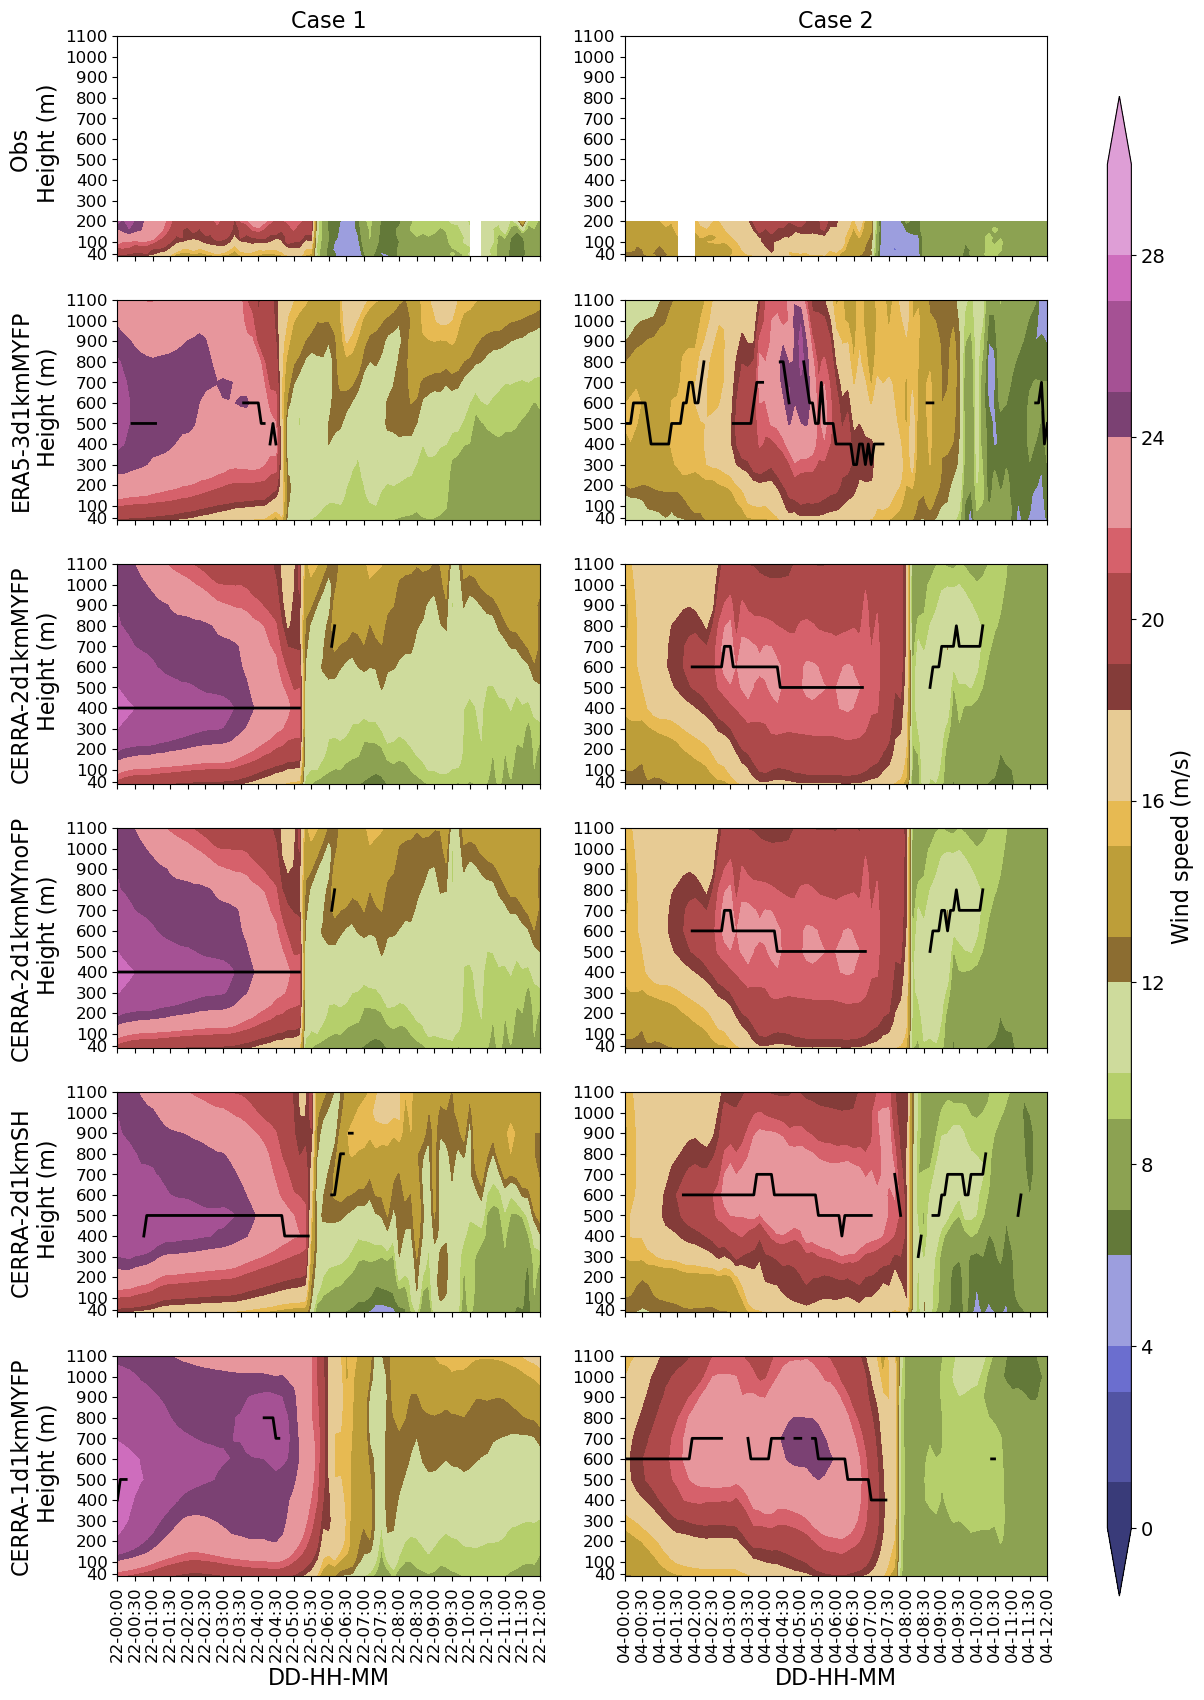

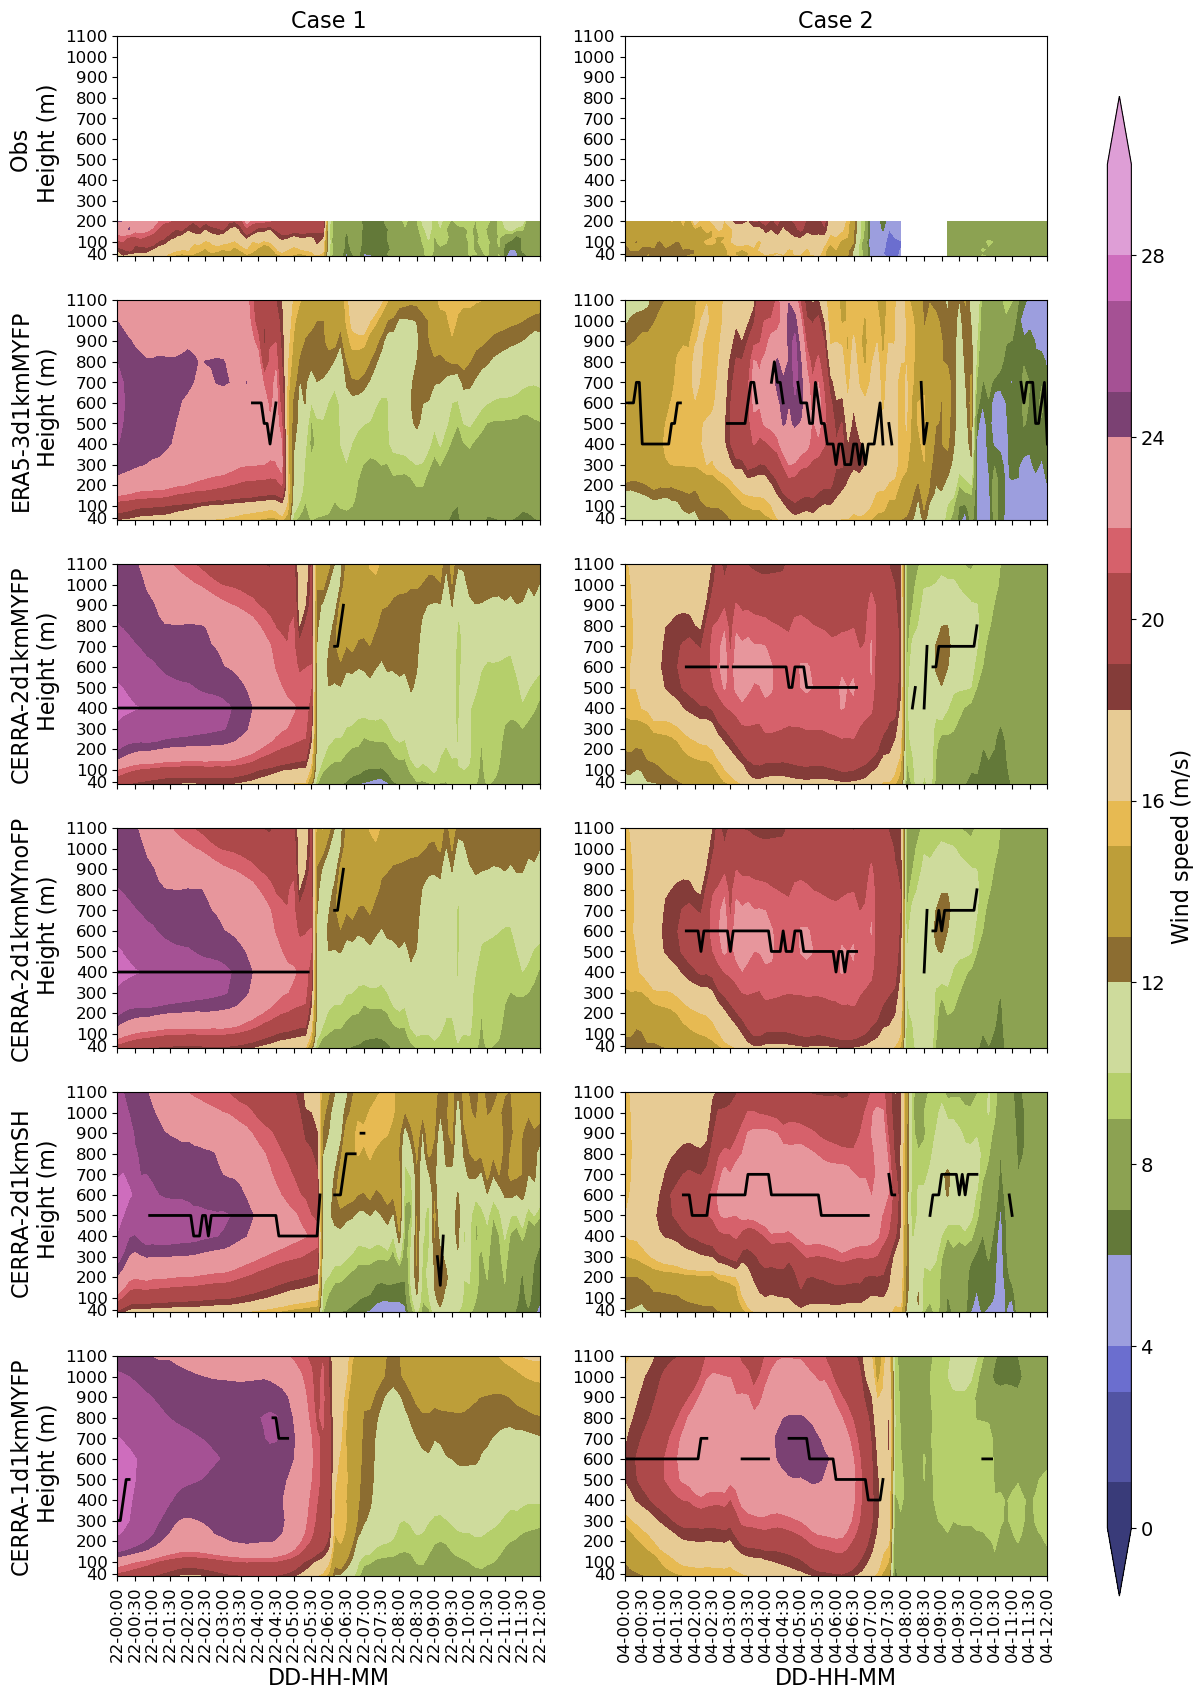

In [226]:
yticks = [40,100,200,300,400,500,600,700,800,900,1000,1100]

for location in ['LOT1','LOT2']:
    fig = plt.figure(figsize=(12, 20))
    gs = plt.GridSpec(6,2,hspace=0.2, wspace=0.2)
    for k,case in enumerate([1,2]):

        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]

        # observations
        obs_ws = ws_dfs[location][0]
        j = 0
        ylabel = f'Obs \n Height (m)' if k == 0 else False
        ax = fig.add_subplot(gs[j,k])
        mapable = plot_time_height_crosssection(ax,obs_ws.index,obs_ws.columns,obs_ws.T,np.arange(0, 31,1),'tab20b',f'Case {case}',xlabel=None,ylabel=ylabel,xticks=False,yticks= yticks)

        j = 1
        for run in [1,2,3,4,5]:
            run_dir = f'WRF_run_{run}'
            ws = ws_dfs[location][j]
            result = LLJ_detection(ws)
            run_name = run_names[run-1]
            ax = fig.add_subplot(gs[j,k])
            xlabel = 'DD-HH-MM' if j == 5 else None
            ylabel = f'{run_name}\n Height (m)' if k == 0 else None
            xticks = True if j == 5 else False

            plot_time_height_crosssection(ax,ws.index[::2],ws.columns,ws[::2].T,np.arange(0, 31,1),'tab20b','',xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks= yticks,jet_heights=result['core_height'])

            j = j+1
    # Adding colorbar
    cbarb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(mapable, cax=cbarb_ax, orientation='vertical',extend='both')
    cbar_barb.ax.set_ylabel('Wind speed (m/s)', fontsize=16)
    cbar_barb.ax.tick_params(labelsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_speed_timeheight_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

## A comparison of 100 m wind speed and direction between ERA5, CERRA, and observations

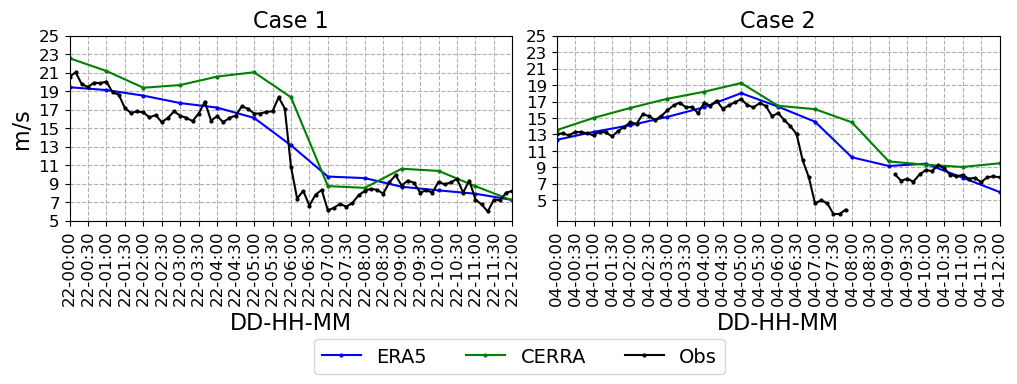

In [159]:
# location indices LOT1: 3, and LOT2: 4
ERA5 = xr.open_dataset(f'{root_dir}/ERA5.nc')
CERRA = xr.open_dataset(f'{root_dir}/2016.nc')

location = 'LOT2'
level = 100
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(2,2,hspace=0.5, wspace=0.1)
for k,case in enumerate([1,2]):
    case_dir = f'FLLJ_{case}'
    j = 0
    ylabel = f'm/s' if k == 0 else False
    xlabel = 'DD-HH-MM'
    xticks = True
    ax = fig.add_subplot(gs[j,k])

    data = ERA5['100ws'].sel(location=4,time=slice(ramp_periods[case-1][0],ramp_periods[case-1][1])) 
    plot_lines_timeseries(ax,data.time.values,data.values,'blue','.','-',f'ERA5',f'Case {case}',
                        xlabel=None,ylabel=ylabel,xticks=False,yticks=np.arange(5, 25.1, 2))
    
    data = CERRA.data.sel(obs=4,time=slice(ramp_periods[case-1][0],ramp_periods[case-1][1]),heightAboveGround=level)
    plot_lines_timeseries(ax,data.time.values,data.values,'green','.','-',f'CERRA',f'Case {case}',
                        xlabel=None,ylabel=ylabel,xticks=False,yticks=np.arange(5, 25.1, 2))
    
    obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],[level],location)
    plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],'black','.','-',f'Obs',f'Case {case}',
                        xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 2))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,0.3),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_speed_timeseries_{location}_reanalysis.pdf', dpi=300, bbox_inches='tight')

### wind power

# Estimate error metric
- For plotting, time instance is not an issue, but for estimating a metric, the simulations and observations should be on same time
- Better create a combined dataframe

In [23]:
def T_metric(O,M):
    '''
    O: observed data
    M: model data
    returns the T-metric
    https://journals.ametsoc.org/view/journals/hydr/18/10/jhm-d-17-0045_1.xml?tab_body=abstract-display
    '''
    R = np.corrcoef(O,M)[0,1]
    MSE = np.mean(D(O,M)**2)
    bias = np.mean(D(O,M))
    std1 = np.std(O)
    std2 = np.std(M)

    T = ((1+R)/2)*(1-(MSE/(bias**2+std1**2+std2**2)))

    return T

In [24]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    grid_power = pd.read_csv(f'{root_dir}/{case_dir}/wind_power(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    for run in [1,2,3,4,5,6,7]:
        SIM = data[f'{run_names[run-1]}']
        OBS = data['obs_power']
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3),round(T_metric(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS','T'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 1:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
    df_all.to_csv(f'{root_dir}/{case_dir}/power_stats(3hCERRA).csv')
    print(df_all)

                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.517 -0.278  0.498  0.758  0.649
CERRA-2d1kmMYFP    0.425 -0.059  0.424  0.815  0.751
CERRA-2d1kmMYnoFP  0.515  0.470  0.466  0.792  0.666
CERRA-2d1kmSH      0.483  0.400  0.449  0.808  0.696
CERRA-1d1kmMYFP    0.208  1.103  0.139  0.974  0.952
CERRA-2d0.5kmSH    0.262  2.348  0.103  0.989  0.930
CERRA-1d0.5kmSH    0.414  1.954  0.189  0.954  0.838
                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.570  0.277  0.550  0.712  0.582
CERRA-2d1kmMYFP    0.450  0.365  0.423  0.824  0.732
CERRA-2d1kmMYnoFP  0.568  0.595  0.488  0.775  0.619
CERRA-2d1kmSH      0.535  0.549  0.469  0.792  0.651
CERRA-1d1kmMYFP    0.233  1.003  0.164  0.973  0.935
CERRA-2d0.5kmSH    0.591  0.835  0.453  0.788  0.629
CERRA-1d0.5kmSH    0.610  1.396  0.355  0.788  0.690


In [25]:
for run in [1,2,3,4,5,6,7]:
    SIM = []
    OBS = []
    for case in [1,2]:
        case_dir = f'FLLJ_{case}'
        grid_power = pd.read_csv(f'{root_dir}/{case_dir}/wind_power(3hCERRA).csv',index_col=0)
        grid_power.index = pd.to_datetime(grid_power.index)
        data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    
        sim = data[f'{run_names[run-1]}']
        obs = data['obs_power']
        SIM.extend(sim.values)
        OBS.extend(obs.values)
    SIM = np.array(SIM)
    OBS = np.array(OBS)
    # crete a dataframe from these three statistics save to a excel
    df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3),round(T_metric(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS','T'],index=[run_names[run-1]])
    # combine dfs for all runs
    if run == 1:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
df_all.to_csv(f'{root_dir}/power_stats(3hCERRA).csv')
print(df_all)

                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.541  0.022  0.541  0.718  0.607
CERRA-2d1kmMYFP    0.437  0.153  0.432  0.813  0.738
CERRA-2d1kmMYnoFP  0.544  0.533  0.480  0.781  0.639
CERRA-2d1kmSH      0.510  0.475  0.461  0.799  0.672
CERRA-1d1kmMYFP    0.221  1.044  0.153  0.976  0.942
CERRA-2d0.5kmSH    0.456  0.923  0.335  0.886  0.767
CERRA-1d0.5kmSH    0.518  1.499  0.287  0.880  0.757


- CERRA-MYFP1d is better in power statistics

### wind speed

In [26]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    ws_dfs = ws_dict[case]
    j = 1
    for run in [1,2,3,4,5,6,7]:
        run_name = run_names[run-1] if run != 15 else 'CERRA-1d1kmSH'
        OBS = []
        SIM = []
        for location in ['LOT1','LOT2']:
            obs = ws_dfs[location][0].copy()
            sim = ws_dfs[location][j].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
        OBS = np.array(OBS)
        SIM = np.array(SIM)
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3),round(T_metric(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS','T'],index=[run_name])
        # combine dfs for all runs
        if run == 1:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
        j = j+1
    #df_all.to_csv(f'{root_dir}/{case_dir}/ws_stats(3hCERRA).csv')
    print(df_all)

                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.401 -0.023  0.401  0.846  0.772
CERRA-2d1kmMYFP    0.328  0.451  0.299  0.907  0.857
CERRA-2d1kmMYnoFP  0.348  0.543  0.306  0.900  0.844
CERRA-2d1kmSH      0.257  0.171  0.253  0.937  0.904
CERRA-1d1kmMYFP    0.445  1.021  0.311  0.898  0.784
CERRA-2d0.5kmSH    0.335  0.651  0.281  0.922  0.857
CERRA-1d0.5kmSH    0.424  0.862  0.321  0.899  0.791
                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.592  0.271  0.572  0.699  0.550
CERRA-2d1kmMYFP    0.628  0.562  0.547  0.719  0.546
CERRA-2d1kmMYnoFP  0.645  0.600  0.553  0.712  0.531
CERRA-2d1kmSH      0.651  0.354  0.614  0.658  0.483
CERRA-1d1kmMYFP    0.561  0.787  0.441  0.814  0.650
CERRA-2d0.5kmSH    0.621  0.595  0.533  0.736  0.558
CERRA-1d0.5kmSH    0.636  0.592  0.548  0.707  0.543


In [27]:
j = 1
for run in [1,2,3,4,5,6,7]:
    OBS = []
    SIM = []
    for case in [1,2]:
        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]
        for location in ['LOT1','LOT2']:
            obs = ws_dfs[location][0].copy()
            sim = ws_dfs[location][j].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
    OBS = np.array(OBS)
    SIM = np.array(SIM)
    # crete a dataframe from these three statistics save to a excel
    df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3),round(T_metric(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS','T'],index=[run_names[run-1]])
    # combine dfs for all runs
    if run == 1:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
    j = j+1
df_all.to_csv(f'{root_dir}/ws_stats(3hCERRA).csv')
print(df_all)

                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.498  0.140  0.493  0.772  0.662
CERRA-2d1kmMYFP    0.483  0.496  0.433  0.816  0.705
CERRA-2d1kmMYnoFP  0.500  0.554  0.438  0.812  0.693
CERRA-2d1kmSH      0.477  0.271  0.460  0.799  0.694
CERRA-1d1kmMYFP    0.495  0.889  0.370  0.864  0.727
CERRA-2d0.5kmSH    0.484  0.588  0.417  0.833  0.711
CERRA-1d0.5kmSH    0.520  0.692  0.428  0.821  0.684


### wind direction

In [28]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    wdir_dfs = wdir_dict[case]
    for run in range(1,8):
        OBS = []
        SIM = []
        for location in ['LOT1','LOT2']:
            obs = wdir_dfs[location][0].copy()
            sim = wdir_dfs[location][run].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
        OBS = np.array(OBS)
        SIM = np.array(SIM)
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3),round(T_metric(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS','T'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 1:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
    df_all.to_csv(f'{root_dir}/{case_dir}/wdir_stats(3hCERRA).csv')
    print(df_all)

                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.693  0.557  0.606  0.593  0.482
CERRA-2d1kmMYFP    0.525  0.745  0.421  0.782  0.701
CERRA-2d1kmMYnoFP  0.524  0.786  0.412  0.792  0.704
CERRA-2d1kmSH      0.460  0.576  0.398  0.821  0.746
CERRA-1d1kmMYFP    0.460  0.211  0.450  0.770  0.724
CERRA-2d0.5kmSH    0.415  0.501  0.371  0.835  0.789
CERRA-1d0.5kmSH    0.451  0.248  0.438  0.788  0.733
                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.507 -0.040  0.507  0.747  0.651
CERRA-2d1kmMYFP    0.349  0.820  0.270  0.928  0.852
CERRA-2d1kmMYnoFP  0.352  0.830  0.271  0.928  0.850
CERRA-2d1kmSH      0.319  0.526  0.282  0.918  0.866
CERRA-1d1kmMYFP    0.333  0.889  0.249  0.939  0.867
CERRA-2d0.5kmSH    0.305  0.520  0.270  0.928  0.876
CERRA-1d0.5kmSH    0.300  0.594  0.258  0.933  0.882


In [29]:
for run in range(1,8):
    OBS = []
    SIM = []
    for case in [1,2]:
        case_dir = f'FLLJ_{case}'
        wdir_dfs = wdir_dict[case]
        for location in ['LOT1','LOT2']:
            obs = wdir_dfs[location][0].copy()
            sim = wdir_dfs[location][run].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
    OBS = np.array(OBS)
    SIM = np.array(SIM)
    # crete a dataframe from these three statistics save to a excel
    df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3),round(T_metric(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS','T'],index=[run_names[run-1]])
    # combine dfs for all runs
    if run == 1:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
df_all.to_csv(f'{root_dir}/wdir_stats(3hCERRA).csv')
print(df_all)

                   NRMSE  NBIAS    NPE    TSS      T
ERA5-3d1kmMYFP     0.441  0.225  0.430  0.823  0.733
CERRA-2d1kmMYFP    0.341  0.781  0.269  0.927  0.857
CERRA-2d1kmMYnoFP  0.343  0.808  0.266  0.929  0.857
CERRA-2d1kmSH      0.307  0.550  0.269  0.929  0.875
CERRA-1d1kmMYFP    0.321  0.489  0.289  0.910  0.865
CERRA-2d0.5kmSH    0.286  0.510  0.255  0.935  0.890
CERRA-1d0.5kmSH    0.299  0.403  0.277  0.923  0.877


# wind speed profile

In [56]:
from matplotlib.ticker import MultipleLocator
def plot_wind_profile(ax, data, levels, color,line_style, marker, label, xlabel, ylabel, title, xticks, yticks):
    ax.plot(data, levels, line_style, color=color, marker=marker, label=label, markersize=4, linewidth=2)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.xaxis.set_minor_locator(MultipleLocator(1))  # Set minor ticks at every 1 value
        ax.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)  # Hide minor tick labels
    if yticks is not None:
        ax.set_yticks(yticks)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=16)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=16)
    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

    return ax

22T03:00 2016-02-22T04:00
22T04:00 2016-02-22T05:00
22T05:00 2016-02-22T06:00
04T04:30 2016-03-04T05:30
04T05:30 2016-03-04T06:30
04T06:30 2016-03-04T07:30
22T03:00 2016-02-22T04:00
22T04:00 2016-02-22T05:00
22T05:00 2016-02-22T06:00
04T04:30 2016-03-04T05:30
04T05:30 2016-03-04T06:30
04T06:30 2016-03-04T07:30


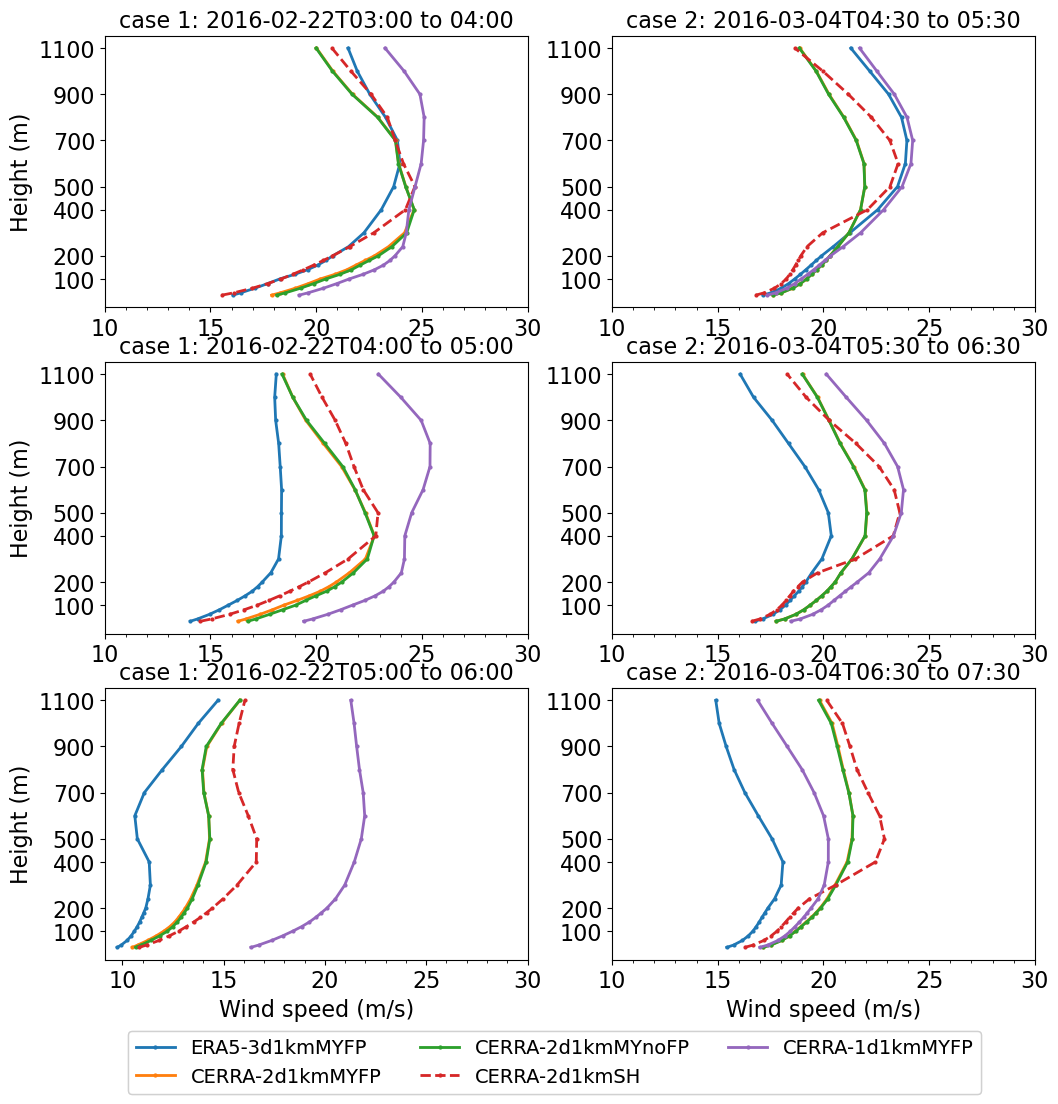

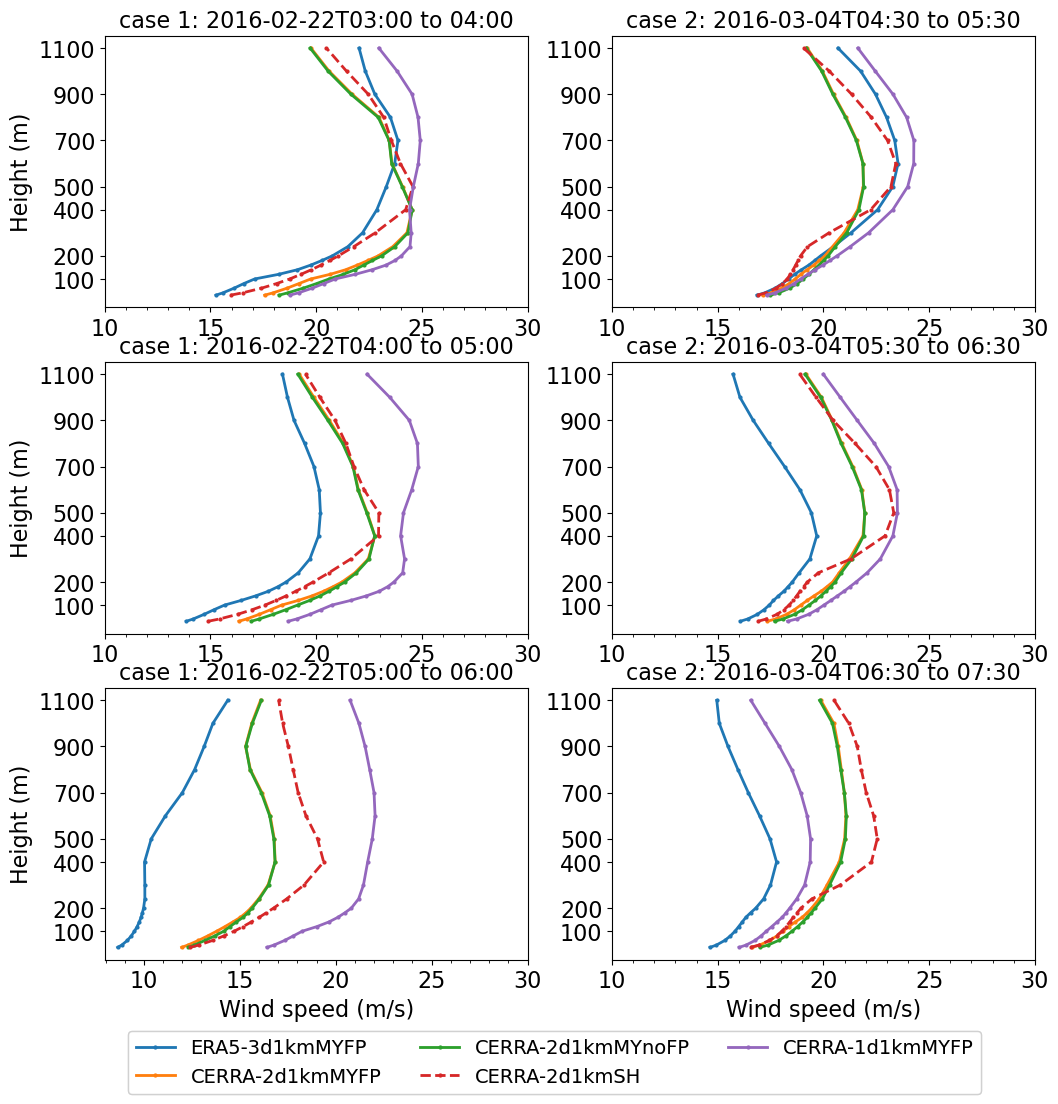

In [60]:
# create 10 colors and 10 markers
colors = sns.color_palette("tab10", 10)
markers = ['o','s','^','v','<','>','1','2','3','4','5']
linestyles = ['-','-','-','--','-','--','--']
time_instances = ['2016-02-22T04:00','2016-03-04T07:45']

for location in ['LOT1','LOT2']:
    fig = plt.figure(figsize=(12, 12))
    gs = plt.GridSpec(3,2)
    for i,case in enumerate([1,2]):
        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]
        for j,hour in enumerate(range(3,0,-1)):
            instance_start = ((datetime.strptime(time_instances[case-1], '%Y-%m-%dT%H:%M'))-timedelta(hours=hour)).strftime('%Y-%m-%dT%H:%M')
            instance_end = ((datetime.strptime(instance_start, '%Y-%m-%dT%H:%M'))+timedelta(hours=1)).strftime('%Y-%m-%dT%H:%M')
            print(instance_start[-8:],instance_end)

            xlabel = 'Wind speed (m/s)' if j == 2 else None
            ylabel = 'Height (m)' if i == 0 else None
            title = f'case {case}: {instance_start} to {instance_end[-5:]}'
            xticks = np.arange(10,30.1,5)
            yticks = [100, 200, 400, 500, 700, 900, 1100]
            ax = fig.add_subplot(gs[j,i])

            #OBS = ws_dfs[location][0][instance_start:instance_end]
            #plot_wind_profile(ax,np.squeeze(OBS.mean().values), OBS.columns,'black','-', 'o', f'{location} observed', xlabel, ylabel, title, xticks, yticks)
            for run in [1,2,3,4,5]:
                run_dir = f'WRF_run_{run}'
                SIM = ws_dfs[location][run][instance_start:instance_end]
                plot_wind_profile(ax,np.squeeze(SIM.mean().values),SIM.columns,colors[run-1],linestyles[run-1],'.',run_names[run-1],xlabel, ylabel, title, xticks, yticks)

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.01),fontsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_{location}_jet_wind_speed_profiles(3hCERRA).pdf', dpi=300, bbox_inches='tight')

# wind speed profiles from ERA5 and CERRA reanalysis

In [74]:
# Writing a function to extract location wise data based on XLAT and XLONG
def nearest_indices(ds, target_lat, target_lon):
    ds_single_time = ds.isel(Time=0)
    start = time.time()
    # Calculate the squared distance to each grid point
    distance_squared = (ds_single_time.XLAT_M - target_lat)**2 + (ds_single_time.XLONG_M - target_lon)**2
    end = time.time()
    print(f'Time elapsed for nearest point identification is {end-start}s')
    # Find the indices of the nearest grid point
    indices = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    return indices

Time elapsed for nearest point identification is 0.0051000118255615234s
Time elapsed for nearest point identification is 0.004917144775390625s
Time elapsed for nearest point identification is 0.004692554473876953s
Time elapsed for nearest point identification is 0.0051538944244384766s


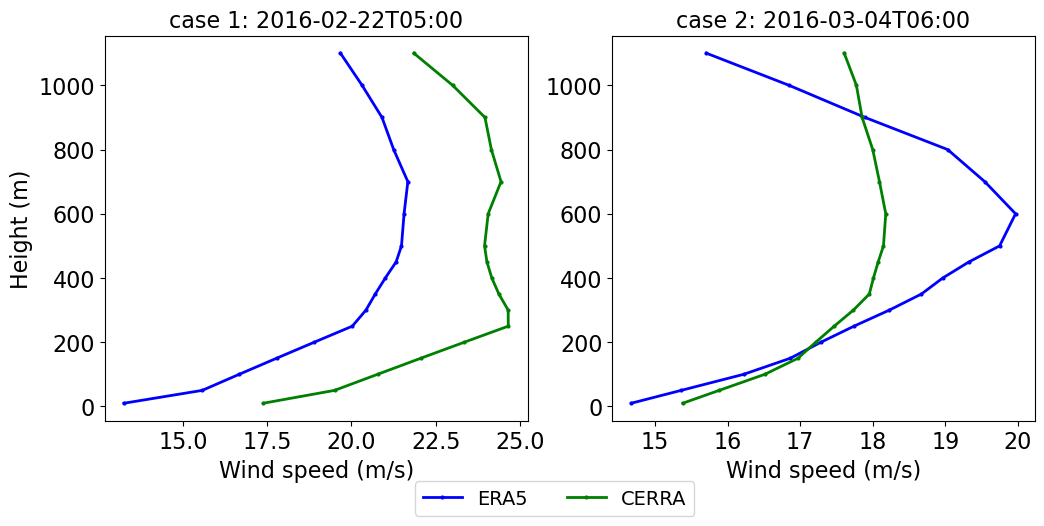

In [115]:
levels = [10,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000,1100]
instances = ['2016-02-22T05:00','2016-03-04T06:00']
location = 'LOT2'
fig = plt.figure(figsize=(12, 5))
gs = plt.GridSpec(1,2)
for case in [1,2]:
    ax = fig.add_subplot(gs[0,case-1])
    xlabel = 'Wind speed (m/s)'
    ylabel = 'Height (m)' if case == 1 else None

    files = glob.glob(f"{root_dir}/FLLJ_{case}/WPS_run_1/metfiles/met_em.d01*")
    ds = xr.open_mfdataset(files,
                                combine='nested',
                                concat_dim='Time',
                                chunks={'Time':-1},
                                parallel=True)
    Times = pd.to_datetime(np.char.decode(ds.Times, 'utf-8'), format='%Y-%m-%d_%H:%M:%S')
    ds = ds.assign_coords(Time=Times)
    indices = nearest_indices(ds,buoy_locations[location][0],buoy_locations[location][1])
    UU = ((ds.UU.sel(west_east_stag=slice(1,None))+ds.UU.sel(west_east_stag=slice(None,-1)))*0.5).rename({'west_east_stag':'west_east'})
    VV = ((ds.VV.sel(south_north_stag=slice(1,None))+ds.VV.sel(south_north_stag=slice(None,-1)))*0.5).rename({'south_north_stag':'south_north'})
    UU_interp = wrf.interplevel(UU,ds.GHT,levels)
    VV_interp = wrf.interplevel(VV,ds.GHT,levels)
    UU_timeseries = UU_interp.isel(south_north=indices[0],west_east=indices[1])
    VV_timeseries = VV_interp.isel(south_north=indices[0],west_east=indices[1])
    wind = (np.sqrt(UU_timeseries**2+VV_timeseries**2)).sel(Time=instances[case-1])
    plot_wind_profile(ax,np.squeeze(wind.values),wind.level,'blue','-','.','ERA5',xlabel, ylabel, f'case {case}: {instances[case-1]}', None, None)

    files = glob.glob(f"{root_dir}/FLLJ_{case}/WPS_run_5/metfiles/met_em.d01*")
    ds = xr.open_mfdataset(files,
                                combine='nested',
                                concat_dim='Time',
                                chunks={'Time':-1},
                                parallel=True)
    Times = pd.to_datetime(np.char.decode(ds.Times, 'utf-8'), format='%Y-%m-%d_%H:%M:%S')
    ds = ds.assign_coords(Time=Times)
    indices = nearest_indices(ds,buoy_locations[location][0],buoy_locations[location][1])
    UU = ((ds.UU.sel(west_east_stag=slice(1,None))+ds.UU.sel(west_east_stag=slice(None,-1)))*0.5).rename({'west_east_stag':'west_east'})
    VV = ((ds.VV.sel(south_north_stag=slice(1,None))+ds.VV.sel(south_north_stag=slice(None,-1)))*0.5).rename({'south_north_stag':'south_north'})
    UU_interp = wrf.interplevel(UU,ds.GHT,levels)
    VV_interp = wrf.interplevel(VV,ds.GHT,levels)
    UU_timeseries = UU_interp.isel(south_north=indices[0],west_east=indices[1])
    VV_timeseries = VV_interp.isel(south_north=indices[0],west_east=indices[1])
    wind = (np.sqrt(UU_timeseries**2+VV_timeseries**2)).sel(Time=instances[case-1])
    plot_wind_profile(ax,np.squeeze(wind.values),wind.level,'green','-','.','CERRA',xlabel, ylabel, f'case {case}: {instances[case-1]}', None, None)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.1),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_{location}_jet_wind_speed_profiles_reanalysis.pdf', dpi=300, bbox_inches='tight')

# Profiles at  Herstmonceux Radiosonde cite 

/media/harish/SSD_4TB/EU_SCORES_project/WRFV4.4/FLLJ/FLLJ_1/observations/Herstomonceux_2016022200.csv
/media/harish/SSD_4TB/EU_SCORES_project/WRFV4.4/FLLJ/FLLJ_2/observations/Herstomonceux_2016030400.csv


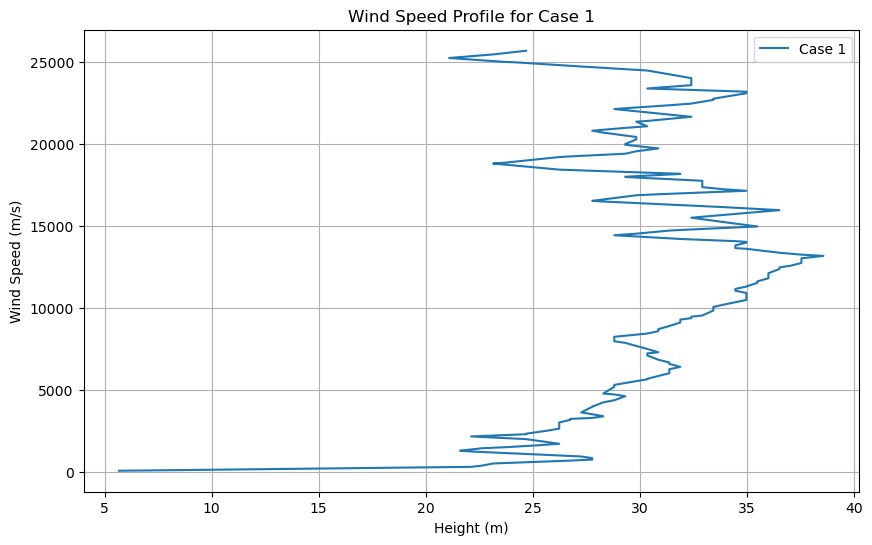

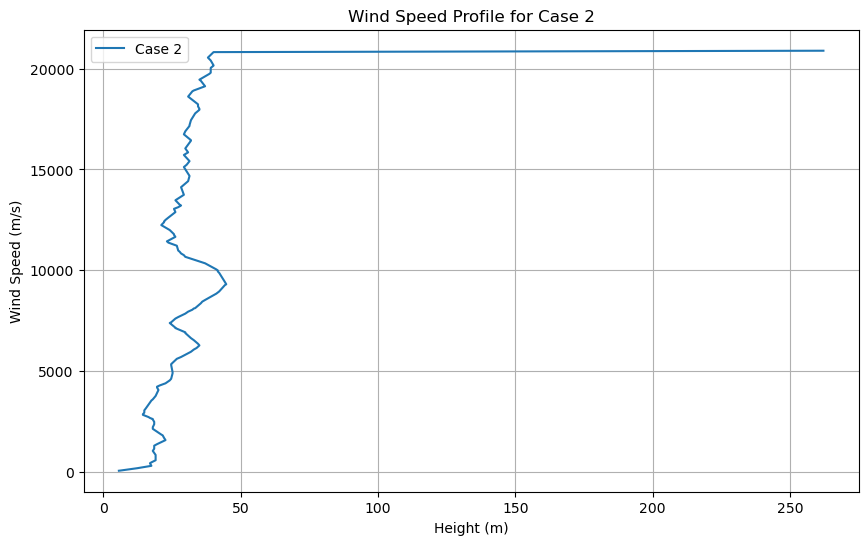

In [269]:
for case in [1,2]:
    file = glob.glob(f'{root_dir}/FLLJ_{case}/observations/Herstomonceux_*.csv')[0]
    print(file)
    df = pd.read_csv(file,skiprows=[1],header=0,index_col=1)
    # Convert wind speed from knots to m/s
    df['SKNT'] = df['SKNT'] * 0.514444
    
    # Plot HGT on the x-axis and SKNT on the y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(df['SKNT'],df.index, label=f'Case {case}')
    plt.xlabel('Height (m)')
    plt.ylabel('Wind Speed (m/s)')
    plt.title(f'Wind Speed Profile for Case {case}')
    plt.legend()
    plt.grid(True)

plt.show()

# Other events

In [264]:
df

PRES  TEMP  DWPT  RELH  MIXR  DRCT       SKNT   THTA   THTE   THTV
HGHT                                                                       
52     1004.0  10.2   9.5    95  7.47   285   5.658884  283.0  303.8  284.3
86     1000.0  10.0   9.3    95  7.40   274   8.231104  283.1  303.7  284.4
195     987.0   9.2   8.8    97  7.24   240  15.947764  283.4  303.6  284.7
288     976.0   8.6   8.4    99  7.11   240  22.121092  283.7  303.5  284.9
365     967.0   8.0   8.0   100  7.00   246  22.635536  283.9  303.4  285.1
...       ...   ...   ...   ...   ...   ...        ...    ...    ...    ...
24965    24.0 -60.6 -91.6     1  0.00   265  24.178868  616.9  616.9  616.9
24992    23.9 -60.7 -91.7     1  0.00   266  23.664424  617.4  617.4  617.4
25229    23.0 -62.3 -92.7     1  0.00   280  21.092204  619.6  619.7  619.6
25447    22.2 -63.7 -93.7     1  0.00   278  23.149980  621.7  621.7  621.7
25672    21.4 -63.9 -93.9     1  0.00   276  24.693312  627.6  627.6  627.6

[179 rows x 10 columns]

## Time series of wind power for different events

In [195]:
event_periods = [['2016-02-21T18:00','2016-02-22T18:00'],['2016-03-03T18:00','2016-03-04T18:00'],
                 ['2016-02-09-T00:00','2016-02-10-T00:00'],['2017-01-09-T12:00','2017-01-10-T12:00'],
                 ['2017-01-29-T12:00','2017-01-30-T12:00']] # don't put seconds in the time string
ramp_periods = [['2016-02-22T01:00','2016-02-22T12:00'],['2016-03-04T02:00','2016-03-04T13:00'],
                ['2016-02-09-T01:00','2016-02-09-T12:00'],['2017-01-09-T18:00','2017-01-10-T06:00'],
                 ['2017-01-30-T01:00','2017-01-30-T12:00']]


for case in [3,4,5]:
    case_dir = f'FLLJ_{case}'
    '''
    The observed wind power at the grid are indeed stored at UTC.
    '''
    grid_power_file = f"{root_dir}/Elia_wind_power/Elia_wind_power.csv"
    grid_power = pd.read_csv(grid_power_file, index_col=0)
    #grid_power = grid_power.iloc[:-4,1:2] if case == 1 else grid_power.iloc[:-4,1:2]
    #grid_power.index = pd.date_range(start=event_periods[case-1][0], end=event_periods[case-1][1], freq='15T')
    grid_power = grid_power.rename_axis('times')
    grid_power.index = pd.to_datetime(grid_power.index)
    # Rename the first column to 'obs_power'
    grid_power = grid_power.rename(columns={'Measured & upscaled [MW]': 'obs_power'})
    grid_power = grid_power.loc[event_periods[case-1][0]:event_periods[case-1][1],['obs_power']]

    print(grid_power.head())
    for run in [5,7]:
        run_dir = f'WRF_run_{run}'
        files = glob.glob(f'{root_dir}/{case_dir}/{run_dir}/turbine_power.nc')
        ds = xr.open_dataset(files[0])
        # Check if 'power' exists in the dataset's variable names, otherwise check for 'POWER'
        var_name = 'power' if 'power' in ds else 'POWER'
        if case == 1 and run == 8:
            grid_power[run_names[run-1]] = ds[var_name].values/1e6
        elif run == 3 or run == 4 or run == 6 or run == 7:
            grid_power[run_names[run-1]] = ds[var_name].values[::3]/1e3 
        else:
            grid_power[run_names[run-1]] = ds[var_name].values[::3]/1e6
    
    grid_power.to_csv(f'{root_dir}/{case_dir}/wind_power(3hCERRA).csv')

                     obs_power
times                         
2016-02-09 00:00:00     614.95
2016-02-09 00:15:00     614.95
2016-02-09 00:30:00     614.95
2016-02-09 00:45:00     614.95
2016-02-09 01:00:00     614.95
                     obs_power
times                         
2017-01-09 12:00:00     354.30
2017-01-09 12:15:00     348.10
2017-01-09 12:30:00     367.36
2017-01-09 12:45:00     452.72
2017-01-09 13:00:00     487.85
                     obs_power
times                         
2017-01-29 12:00:00     438.10
2017-01-29 12:15:00     439.24
2017-01-29 12:30:00     423.42
2017-01-29 12:45:00     393.43
2017-01-29 13:00:00     376.77


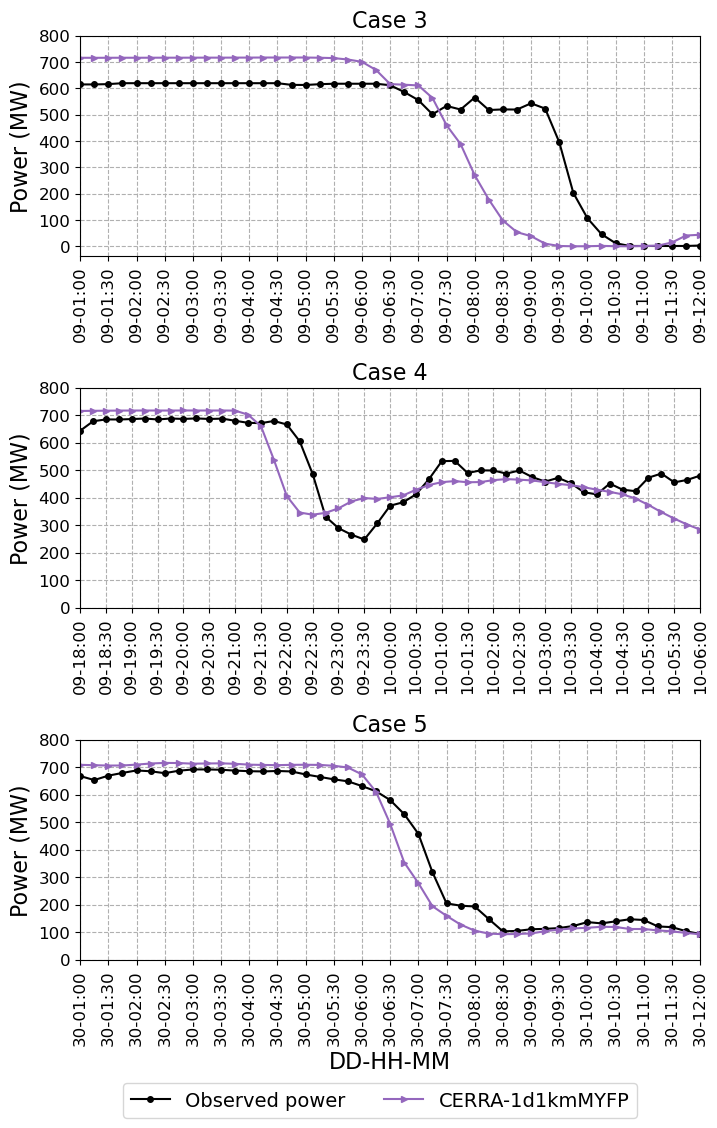

In [200]:
# create 10 custom colors, custom markers
colors = sns.color_palette("tab10", 10)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','5']
fig = plt.figure(figsize=(8, 12))
gs = plt.GridSpec(3,1,hspace=0.6)
for i,case in enumerate([3,4,5]):
    ax = fig.add_subplot(gs[i])
    xticks=True
    xlabel = 'DD-HH-MM' if i == 2 else None
    title = f'Case {case}'
    grid_power = pd.read_csv(f'{root_dir}/FLLJ_{case}/wind_power(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    for run in [5]:
        plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[run],'-',run_names[run-1],title,
                              xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.03),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_3,4,5_wind_power_timeseries(3hCERRA).pdf', dpi=300, bbox_inches='tight')

### Ramp

In [94]:
for case in [3,4,5]:
    my_list = []
    grid_power = pd.read_csv(f'{root_dir}/FLLJ_{case}/wind_power(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    times = pd.DataFrame(data.index)
    rated_power = 712.2
    obs_power = data[f'obs_power']
    cf_grid = obs_power/rated_power
    for j in [1,2,4]: #Loops through 15 min, 30min, and 1hr
        dmy = []
        del_cf_grid = np.array([(cf_grid.iloc[i+j]-cf_grid.iloc[i])*100 for i in range(len(cf_grid)-j)])
        dmy.append(round(np.min(del_cf_grid),1)*-1)
        dmy.append(times['times'].iloc[np.argmin(del_cf_grid)].strftime('%H:%M'))
        for run in [5,7]:
            label = run_names[run-1]
            wrf_power = data[f'{label}']
            cf_wrf = wrf_power/rated_power
            del_cf_wrf = np.array([(cf_wrf.iloc[i+j]-cf_wrf.iloc[i])*100 for i in range(len(cf_wrf)-j)])
            dmy.append(round(np.min(del_cf_wrf),1)*-1)
            dmy.append(times['times'].iloc[np.argmin(del_cf_wrf)].strftime('%H:%M'))
        my_list.append(dmy)
    multiindex_tuples = []
    multiindex_tuples.append(('Grid_power', 'Delta_CF'))
    multiindex_tuples.append(('Grid_power', 'Time_instance'))
    for run in [5,7]:
        label = run_names[run-1]
        multiindex_tuples.append((label, 'Delta_CF'))
        multiindex_tuples.append((label, 'Time_instance'))
    columns = pd.MultiIndex.from_tuples(multiindex_tuples)
    index = ['15min','30min','1hr']
    df = pd.DataFrame(my_list,columns=columns,index=index)
    print(df.head())
    df.to_excel(f'{root_dir}/FLLJ_{case}/cf_ramp(3hCERRA).xlsx')

      Grid_power               CERRA-MYFP1d               CERRA-SH0.5km1d  \
        Delta_CF Time_instance     Delta_CF Time_instance        Delta_CF   
15min       27.1         09:30         16.6         07:45            24.2   
30min       45.0         09:15         29.6         07:45            39.8   
1hr         67.0         09:15         54.2         07:15            64.0   

                     
      Time_instance  
15min         07:45  
30min         07:45  
1hr           07:30  
      Grid_power               CERRA-MYFP1d               CERRA-SH0.5km1d  \
        Delta_CF Time_instance     Delta_CF Time_instance        Delta_CF   
15min       21.8         22:30         18.5         21:45            11.9   
30min       38.4         22:15         35.7         21:30            22.3   
1hr         52.9         22:00         49.9         21:15            31.3   

                     
      Time_instance  
15min         21:45  
30min         21:45  
1hr           21:30  
      Gr

In [77]:
df

Grid_power               CERRA-MYFP1d               CERRA-SH0.5km1d  \
        Delta_CF Time_instance     Delta_CF Time_instance        Delta_CF   
15min       19.6         07:00         19.8         06:30            16.2   
30min       35.5         07:00         36.1         06:15            26.3   
1hr         52.7         06:30         58.4         06:15            41.4   

                     
      Time_instance  
15min         07:00  
30min         07:00  
1hr           06:30

### Evaluation metrics

In [277]:
for case in [3,4,5]:
    case_dir = f'FLLJ_{case}'
    grid_power = pd.read_csv(f'{root_dir}/{case_dir}/wind_power(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    for run in [5,7]:
        SIM = data[f'{run_names[run-1]}']
        OBS = data['obs_power']
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3),round(T_metric(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS','T'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 5:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
    df_all.to_csv(f'{root_dir}/{case_dir}/power_stats(3hCERRA).csv')
    print(df_all)

                 NRMSE  NBIAS    NPE    TSS      T
CERRA-1d1kmMYFP  0.492 -0.058  0.491  0.770  0.668
CERRA-1d0.5kmSH  0.523  0.163  0.516  0.748  0.632
                 NRMSE  NBIAS    NPE    TSS      T
CERRA-1d1kmMYFP  0.448 -0.230  0.437  0.813  0.727
CERRA-1d0.5kmSH  0.871  1.022  0.609  0.548  0.394
                 NRMSE  NBIAS    NPE    TSS      T
CERRA-1d1kmMYFP  0.140 -0.151  0.138  0.976  0.973
CERRA-1d0.5kmSH  0.142  1.736  0.071  0.992  0.979


## Extract wind speed and direction data and save to a dataframe dictonary

In [79]:
ws_dict = {}
wdir_dict = {}
for case in [5]:
    ws_dict[case] = {}
    case_dir = f'FLLJ_{case}'
    ws_dfs = {}
    wdir_dict[case] = {}
    wdir_dfs = {}
    for location in ['LOT1']: # No observatios in LOT2 during the 4th and 5th events
        ws_dfs[location] = []
        wdir_dfs[location] = []
        # observations
        obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],obs_levels,location)
        ws_dfs[location].append(obs_ws)
        wdir_dfs[location].append(obs_wdir)
        # simulations
        for run in [5,7]:
            run_dir = f'WRF_run_{run}'
            u,v,_,_= extract_u_v(root_dir, case_dir,run,run_dir,dates_range=ramp_periods[case-1],levels=[30,1100],location=buoy_locations[location])
            ws = wind_speed(u,v).drop_vars({'XLAT','XLONG'}).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='ws')
            ws_dfs[location].append(ws)
            wdir = wind_direction(u,v).drop_vars({'XLAT','XLONG'}).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='wdir')
            wdir_dfs[location].append(wdir)
    ws_dict[case] = ws_dfs
    wdir_dict[case] = wdir_dfs

Closest indices in the order of latitude (y) and longitude (x) are : (161, 118)
Closest indices in the order of latitude (y) and longitude (x) are : (323, 236)


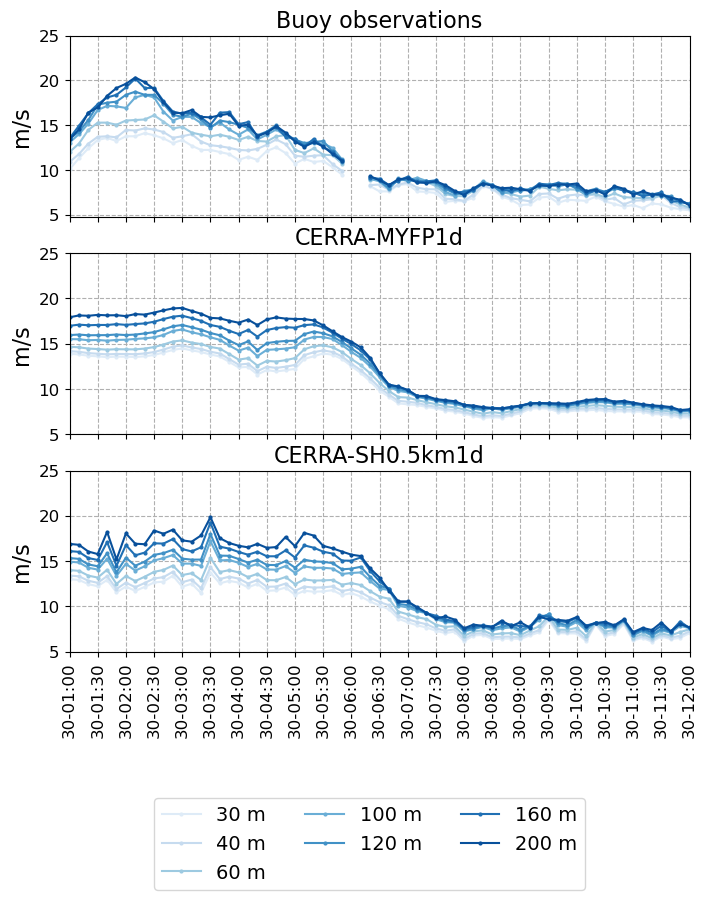

In [82]:
for case in [5]:
    case_dir = f'FLLJ_{case}'
    ws_dfs = ws_dict[case]
    for location in ['LOT1']:
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Blues", len(obs_levels))
        fig = plt.figure(figsize=(8, 8))
        gs = plt.GridSpec(3,1,hspace=0.2, wspace=0.1)

        # observations
        obs_ws = ws_dfs[location][0]
        ax = fig.add_subplot(gs[0,0])
        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel='m/s',xticks=False,yticks=np.arange(5, 25.1, 5))
        j = 1
        for run in [5,7]:
            run_dir = f'WRF_run_{run}'
            ws = ws_dfs[location][j]
            ax = fig.add_subplot(gs[j,0])
            xlabel = 'DD-HH-MM' if j//2 == 3 else None
            ylabel = 'm/s' #if j%2 == 0 else None
            xticks = True if j == 2 else False
            for i,level in enumerate(obs_levels):
                plot_lines_timeseries(ax,ws.index[::2],ws[level][::2],colors[i],'.','-',f'{level} m',run_names[run-1],
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 5))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.2),fontsize=14)
        plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_speed_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

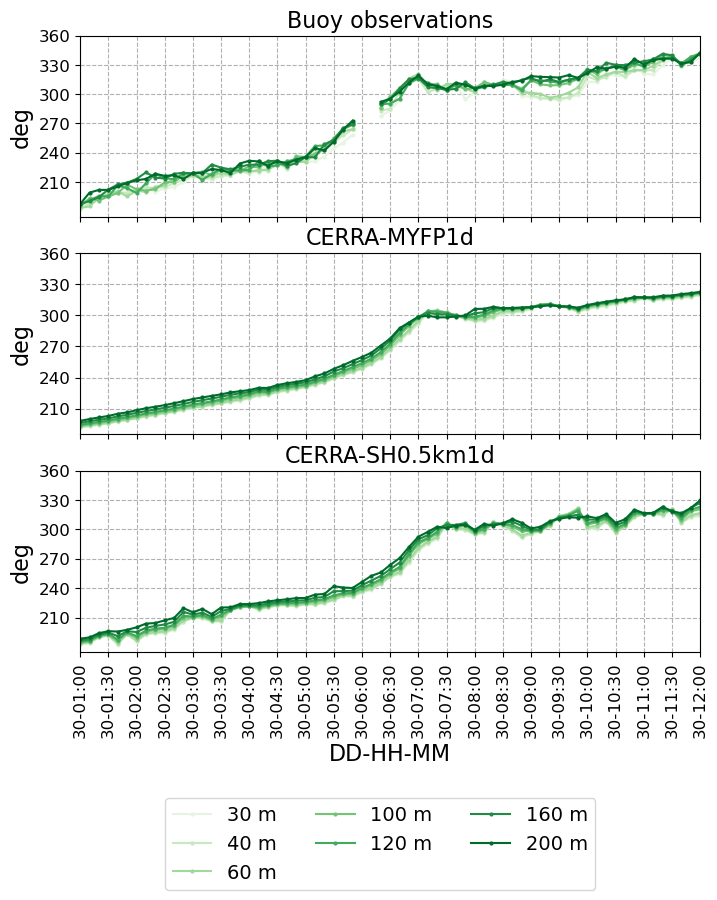

In [83]:
for case in [5]:
    case_dir = f'FLLJ_{case}'
    wdir_dfs = wdir_dict[case]
    for location in ['LOT1']:
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Greens", len(obs_levels))
        fig = plt.figure(figsize=(8, 8))
        gs = plt.GridSpec(3,1,hspace=0.2, wspace=0.1)

        # observations
        obs_wdir = wdir_dfs[location][0]
        ax = fig.add_subplot(gs[0,0])
        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_wdir.index,obs_wdir[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel='deg',xticks=False,yticks=np.arange(210, 360.1, 30))
        j = 1
        for run in [5,7]:
            run_dir = f'WRF_run_{run}'
            wdir = wdir_dfs[location][j]
            ax = fig.add_subplot(gs[j,0])
            xlabel = 'DD-HH-MM' if j == 2 else None
            ylabel = 'deg'# if j%2 == 0 else None
            xticks = True if j == 2 else False
            for i,level in enumerate(obs_levels):
                plot_lines_timeseries(ax,wdir.index[::2],wdir[level][::2],colors[i],'.','-',f'{level} m',run_names[run-1],
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(210, 360.1, 30))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.2),fontsize=14)
        plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_direction_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

### Evaluation statistics

In [84]:
for case in [5]:
    case_dir = f'FLLJ_{case}'
    ws_dfs = ws_dict[case]
    i=1
    for run in [5,7]:
        OBS = []
        SIM = []
        for location in ['LOT1']:
            obs = ws_dfs[location][0].copy()
            sim = ws_dfs[location][i].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
        OBS = np.array(OBS)
        SIM = np.array(SIM)
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 5:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
        i = i+1
    df_all.to_csv(f'{root_dir}/{case_dir}/ws_stats(3hCERRA).csv')
    print(df_all)

                 NRMSE  NBIAS    NPE    TSS
CERRA-MYFP1d     0.304  0.632  0.257  0.935
CERRA-SH0.5km1d  0.309  0.222  0.302  0.910


In [85]:
for case in [5]:
    case_dir = f'FLLJ_{case}'
    wdir_dfs = wdir_dict[case]
    i = 1
    for run in [5,7]:
        OBS = []
        SIM = []
        for location in ['LOT1']:
            obs = wdir_dfs[location][0].copy()
            sim = wdir_dfs[location][i].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
        OBS = np.array(OBS)
        SIM = np.array(SIM)
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 5:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
        i = i+1
    df_all.to_csv(f'{root_dir}/{case_dir}/wdir_stats(3hCERRA).csv')
    print(df_all)

                 NRMSE  NBIAS    NPE    TSS
CERRA-MYFP1d     0.162 -0.744  0.130  0.979
CERRA-SH0.5km1d  0.236 -1.021  0.165  0.972


# Forecasting

## Wind power

In [201]:
event_periods = [['2016-02-21T18:00','2016-02-22T18:00'],['2016-03-03T18:00','2016-03-04T18:00']]
ramp_periods = [['2016-02-22T01:00','2016-02-22T12:00'],['2016-03-04T02:00','2016-03-04T13:00']]

for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    '''
    The observed wind power at the grid are indeed stored at UTC.
    '''
    grid_power_file = f"{root_dir}/Elia_wind_power/Elia_wind_power.csv"
    grid_power = pd.read_csv(grid_power_file, index_col=0)
    #grid_power = grid_power.iloc[:-4,1:2] if case == 1 else grid_power.iloc[:-4,1:2]
    #grid_power.index = pd.date_range(start=event_periods[case-1][0], end=event_periods[case-1][1], freq='15T')
    grid_power = grid_power.rename_axis('times')
    grid_power.index = pd.to_datetime(grid_power.index)
    # Rename the first column to 'obs_power'
    grid_power = grid_power.rename(columns={'Measured & upscaled [MW]': 'obs_power'})
    grid_power = grid_power.rename(columns={'Day-ahead forecast (11h00) [MW]': 'forecast_power'})
    grid_power = grid_power.loc[event_periods[case-1][0]:event_periods[case-1][1],['obs_power','forecast_power']]

    print(grid_power.head())
    j=1
    run = 8
    run_dir = f'WRF_run_{run}'# if run==1 else f'WRF_run_{run+7}'
    files = glob.glob(f'{root_dir}/{case_dir}/{run_dir}/turbine_power.nc')
    ds = xr.open_dataset(files[0])
    # Check if 'power' exists in the dataset's variable names, otherwise check for 'POWER'
    var_name = 'power' if 'power' in ds else 'POWER'
    if case == 1 and run == 8:
        grid_power[run_names[run-1]] = ds[var_name].values/1e6
    elif run == 3 or run == 4 or run == 6 or run == 7:
        grid_power[run_names[run-1]] = ds[var_name].values[::3]/1e3 
    else:
        grid_power[run_names[run-1]] = ds[var_name].values[::3]/1e6
    
    grid_power.to_csv(f'{root_dir}/{case_dir}/wind_power_{run_names[run-1]}(3hCERRA).csv')

                     obs_power  forecast_power
times                                         
2016-02-21 18:00:00     631.03          664.86
2016-02-21 18:15:00     631.03          665.01
2016-02-21 18:30:00     631.03          665.16
2016-02-21 18:45:00     631.03          665.31
2016-02-21 19:00:00     631.03          665.37
                     obs_power  forecast_power
times                                         
2016-03-03 18:00:00      87.69          150.03
2016-03-03 18:15:00      88.86          148.42
2016-03-03 18:30:00      59.92          146.80
2016-03-03 18:45:00      27.77          145.18
2016-03-03 19:00:00      26.02          144.00


                     obs_power  forecast_power  GFS-3d1kmMYFP
times                                                        
2016-02-22 01:00:00     631.03          659.11      716.36260
2016-02-22 01:15:00     631.03          659.29      716.27637
2016-02-22 01:30:00     631.03          659.46      716.41254
2016-02-22 01:45:00     631.03          659.64      716.22400
2016-02-22 02:00:00     631.03          659.62      716.40485
                     obs_power  forecast_power  GFS-3d1kmMYFP
times                                                        
2016-03-04 02:00:00     647.65          574.75       706.9821
2016-03-04 02:15:00     645.28          585.67       710.4145
2016-03-04 02:30:00     648.42          596.59       713.4998
2016-03-04 02:45:00     649.68          607.51       714.6021
2016-03-04 03:00:00     655.87          617.46       716.3049


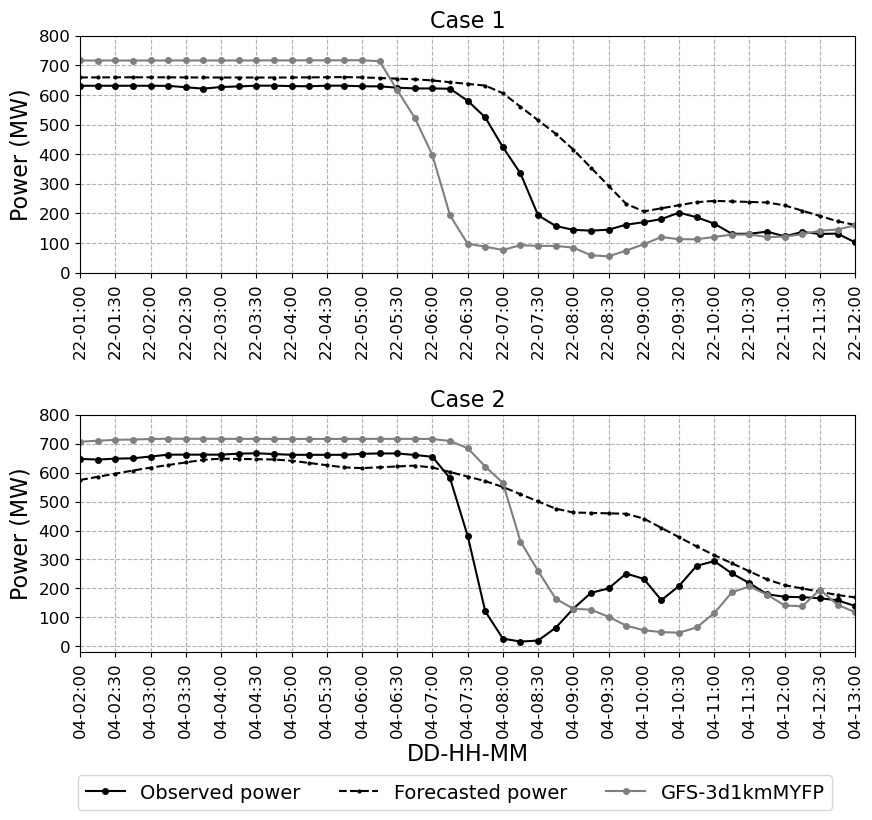

In [213]:
# create 10 custom colors, custom markers
colors = sns.color_palette("tab10", 10)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','5']
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2,1,hspace=0.6)
for i,case in enumerate([1,2]):
    case_dir = f'FLLJ_{case}'
    run = 8
    ax = fig.add_subplot(gs[i])
    grid_power = pd.read_csv(f'{root_dir}/{case_dir}/wind_power_{run_names[run-1]}(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    print(data.head())
    xticks = True
    xlabel = 'DD-HH-MM' if i == 1 else None
    title = f'Case {case}'
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    plot_lines_timeseries(ax,data.index,data['forecast_power'],colors[0],'.','--','Forecasted power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[0],'-',run_names[run-1],title,
                              xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.1),fontsize=14)

plt.savefig(f'{fig_dir}/{run_names[run-1]}_wind_power_timeseries.pdf', dpi=300, bbox_inches='tight')

In [88]:
run = 8

for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    my_list = []
    grid_power = pd.read_csv(f'{root_dir}/{case_dir}/wind_power_{run_names[run-1]}(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    times = pd.DataFrame(data.index)
    rated_power = 712.2
    obs_power = data[f'forecast_power']
    cf_grid = obs_power/rated_power
    for j in [1,2,4]: #Loops through 15 min, 30min, and 1hr
        dmy = []
        del_cf_grid = np.array([(cf_grid.iloc[i+j]-cf_grid.iloc[i])*100 for i in range(len(cf_grid)-j)])
        dmy.append(round(np.min(del_cf_grid),1)*-1)
        dmy.append(times['times'].iloc[np.argmin(del_cf_grid)].strftime('%H:%M'))
        
        label = run_names[run-1]
        wrf_power = data[f'{label}']
        cf_wrf = wrf_power/rated_power
        del_cf_wrf = np.array([(cf_wrf.iloc[i+j]-cf_wrf.iloc[i])*100 for i in range(len(cf_wrf)-j)])
        dmy.append(round(np.min(del_cf_wrf),1)*-1)
        dmy.append(times['times'].iloc[np.argmin(del_cf_wrf)].strftime('%H:%M'))
        my_list.append(dmy)
    multiindex_tuples = []
    multiindex_tuples.append(('Grid_power', 'Delta_CF'))
    multiindex_tuples.append(('Grid_power', 'Time_instance'))

    label = run_names[run-1]
    multiindex_tuples.append((label, 'Delta_CF'))
    multiindex_tuples.append((label, 'Time_instance'))
    columns = pd.MultiIndex.from_tuples(multiindex_tuples)
    index = ['15min','30min','1hr']
    df = pd.DataFrame(my_list,columns=columns,index=index)
    print(df.head())
    df.to_excel(f'{root_dir}/FLLJ_{case}/cf_ramp_{run_names[run-1]}(3hCERRA).xlsx')

      Grid_power               GFS-MYFP              
        Delta_CF Time_instance Delta_CF Time_instance
15min        8.6         08:00     28.6         06:00
30min       17.2         08:00     46.3         05:45
1hr         33.2         07:45     73.1         05:15
      Grid_power               GFS-MYFP              
        Delta_CF Time_instance Delta_CF Time_instance
15min        4.5         10:30     28.5         08:00
30min        9.0         10:15     42.7         08:00
1hr         17.7         10:00     64.2         07:45


In [89]:
run = 8
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    grid_power = pd.read_csv(f'{root_dir}/{case_dir}/wind_power_{run_names[run-1]}(3hCERRA).csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    SIM = data[f'{run_names[run-1]}']
    OBS = data['obs_power']
    # crete a dataframe from these three statistics save to a excel
    df = pd.DataFrame([[round(NRMSE(OBS,SIM),3),round(NBIAS(OBS,SIM),3),round(NPE(OBS,SIM),3),round(Taylor_Skill_Score(OBS,SIM),3)]],columns=['NRMSE','NBIAS','NPE','TSS'],index=[run_names[run-1]])
    # combine dfs for all runs
    df_all = df
    df_all.to_csv(f'{root_dir}/{case_dir}/power_stats_{run_names[run-1]}(3hCERRA).csv')
    print(df_all)

          NRMSE  NBIAS  NPE    TSS
GFS-MYFP   0.41 -0.222  0.4  0.819
          NRMSE  NBIAS    NPE   TSS
GFS-MYFP  0.414  0.297  0.397  0.84


# Time series of wind speed from WRF EU-SCORES
- The UU and VV tslist files contain vertical levels:
- 2, 10, 30, 40, 60, 80, 100, 120, 150, 180, 200, 240, 300, 400, 500, 600, 700, 800, 900, 1000, 1100

In [215]:
tslist_height_levels = [2.0, 10.0, 30.0, 40.0, 60.0, 80.0, 100.0, 
                        120.0, 150.0, 180.0, 200.0, 240.0, 300.0, 400.0, 500.0, 
                        600.0, 700.0, 800.0, 900.0, 1000.0]
# unfortunately, the 1100.0 level hasn't been extracted
def extract_tslist_ws_wdir(root_dir,location,tslist_height_levels,start_time,end_time):
    UU = pd.read_csv(f'{root_dir}/tslist_data_from_WRF_SCORES/{location}_UU.csv',index_col=0)
    UU.index = pd.to_datetime(UU.index)
    UU = UU.loc[start_time:end_time].iloc[::10,1:] # sadly, the first column is timestep, so have to exclude. Also, we need data at every 10 minutes, but our df is saved at every minute.
    UU.columns = tslist_height_levels
    UU.index.names = ['Time']
    
    VV = pd.read_csv(f'{root_dir}/tslist_data_from_WRF_SCORES/{location}_VV.csv',index_col=0)
    VV.index = pd.to_datetime(VV.index)
    VV = VV.loc[start_time:end_time].iloc[::10,1:] # sadly, the first column is timestep, so have to exclude. Also, we need data at every 10 minutes, but our df is saved at every minute.
    VV.columns = tslist_height_levels
    VV.index.names = ['Time']

    ws = np.sqrt(UU**2+VV**2)
    wdir = np.mod(180+np.rad2deg(np.arctan2(UU, VV)),360)
    
    return ws,wdir

In [237]:
tslist_ws_dfs = {}
tslist_wdir_dfs = {}
for location in ['LOT1','LOT2']:
    tslist_ws_dfs[location] = []
    tslist_wdir_dfs[location] = []
    
    ws,wdir = extract_tslist_ws_wdir(root_dir,location,tslist_height_levels,ramp_periods[case-1][0],ramp_periods[case-1][1])
    tslist_ws_dfs[location].append(ws)
    tslist_wdir_dfs[location].append(wdir)

In [242]:
ramp_periods = [['2016-02-22T01:00','2016-02-22T12:00'],['2016-03-04T02:00','2016-03-04T13:00'],
                ['2016-02-09T03:00','2016-02-09T15:00']]

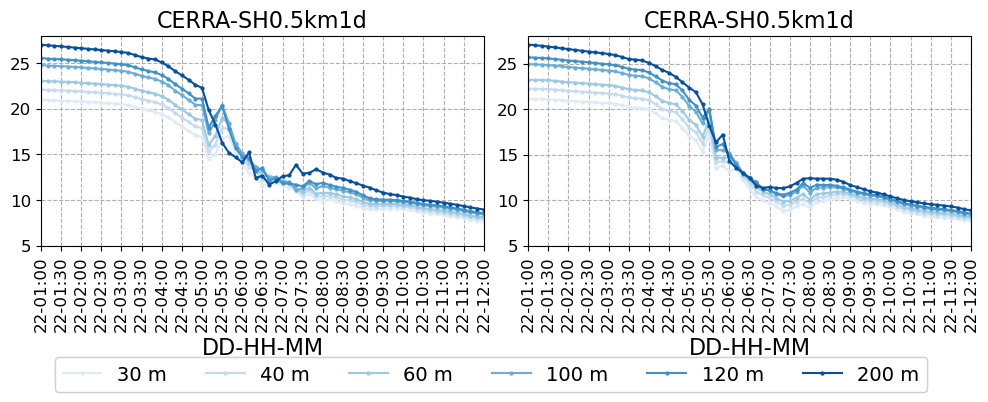

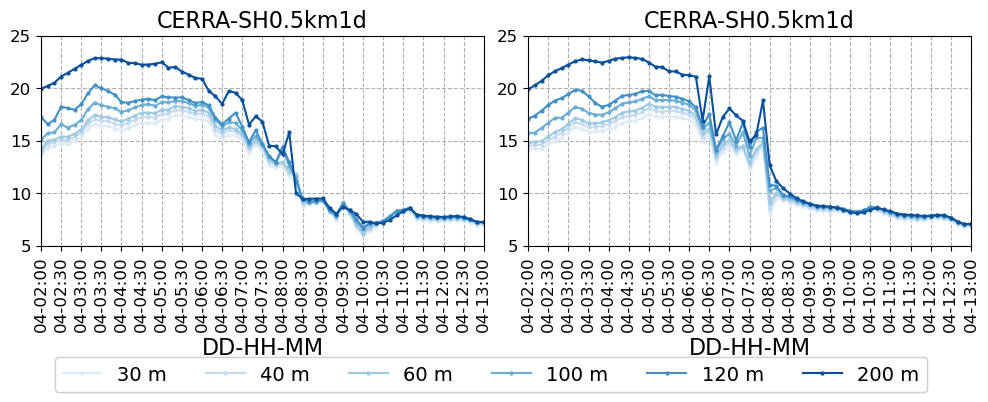

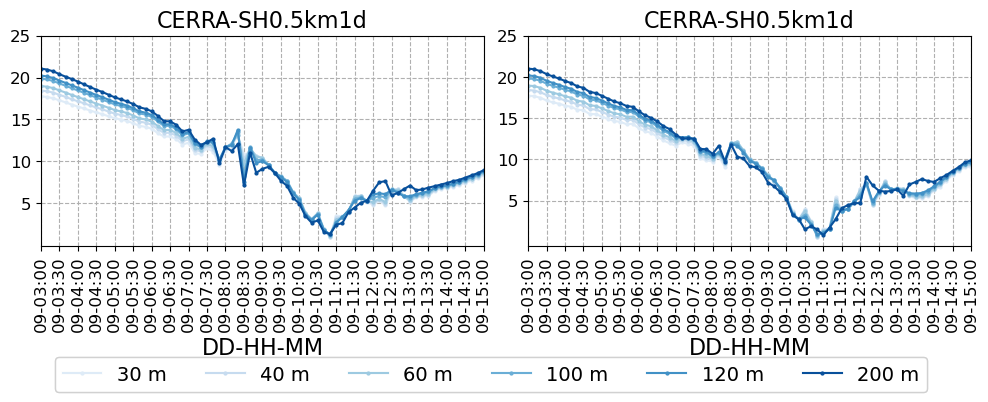

In [243]:
for case in range(1,4):
    case_dir = f'FLLJ_{case}'
    # create a set of 10 colors in blue, from light to dark
    colors = sns.color_palette("Blues", len(obs_levels))
    fig = plt.figure(figsize=(12, 6))
    gs = plt.GridSpec(2,2,hspace=0.2, wspace=0.1)

    tslist_ws_dfs = {}
    tslist_wdir_dfs = {}
    for location in ['LOT1','LOT2']:
        tslist_ws_dfs[location] = []
        tslist_wdir_dfs[location] = []
        
        ws,wdir = extract_tslist_ws_wdir(root_dir,location,tslist_height_levels,ramp_periods[case-1][0],ramp_periods[case-1][1])
        tslist_ws_dfs[location].append(ws)
        tslist_wdir_dfs[location].append(wdir)

    for j,location in enumerate(['LOT1','LOT2']):

        # observations
        '''
        obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],obs_levels,location)
        ax = fig.add_subplot(gs[0,j])

        xlabel = 'DD-HH-MM'
        ylabel = 'm/s' if j == 0 else None
        xticks = True

        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel=ylabel,xticks=False,yticks=np.arange(5, 25.1, 5))
        '''
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.15),fontsize=14)

        ws = tslist_ws_dfs[location][0]
        ax = fig.add_subplot(gs[1,j])

        for i,level in enumerate(obs_levels):
            if level in ws.columns:
                plot_lines_timeseries(ax,ws.index,ws[level],colors[i],'.','-',f'{level} m',run_names[7-1],
                                xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 5))